# OPEN FOOD FACTS: NUTRISCORE
## STEP 1: IMPORT ET NETTOYAGE
### 1-A: import du jeu de donnéees openfoods et visualisation rapide
* jeu volumineux de ***320000 lignes/observations*** et ***162 colonnes/variables***
    * 10 champs d'**informations générales** : nom du produit, date de modification etc ...
    * 24 champs de **tags** : categorie de produit, localisation, origine
    * 29 champs d'**ingrédients et d'additifs**
    * 99 champs **quantitatifs d'informations nutritionnelles** pour 100gr de produit

In [3]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt

from ipywidgets import interact
from ipywidgets import widgets


#########IMPORT
data = pd.read_csv('input/fr.openfoodfacts.org.products.csv', delimiter = '\t',parse_dates=[3,4,5,6],error_bad_lines=False,low_memory=False)
print('le fichier contient ','\033[1m',data.shape[0],'lignes','\033[0m')
print('le fichier contient ','\033[1m',data.shape[1],'colonnes','\033[0m')

#############
datanull=1-(data.isnull().sum()/len(data.index))

#########VISUALISATION RAPIDE INTERACTIVE
    #init bouton widget

layout = widgets.Layout(width='auto', height='80px')
button1 = widgets.RadioButtons(value = None,
                               style={'description_width': 'initial'},
                               options = ['Informations_gererales', 'Tags', 'Ingredients_additifs_cat_grade', 'Informations_nutri_quant'],
                               description = 'TYPES DE VARIABLES',
                               layout=layout)
    #fonction s'affichage des données
    
def evaluate(a):
    #selection = button.get_interact_value()
    if (a == 'Informations_gererales'):
            plt.figure(figsize=(10,2))
            ax = datanull[0:10].plot.barh( color="#8d19a9",title='Pourcentage de données par variable',
                                          xlabel='pourcentage de données')
            display(data.iloc[3:5,0:10])
    elif (a == 'Tags'):
            plt.figure(figsize=(10,5))
            ax = datanull[10:34].plot.barh( color="#8d19a9",title='Pourcentage de données par variable',
                                           xlabel='pourcentage de données')
            display(data.iloc[3:5,10:20])
            display(data.iloc[3:5,20:30])
            display(data.iloc[3:5,30:34])
    elif (a == 'Ingredients_additifs_cat_grade'):
            plt.figure(figsize=(10,5))
            ax = datanull[34:63].plot.barh( color="#8d19a9",title='Pourcentage de données par variable',
                                           xlabel='pourcentage de données')
            display(data.iloc[3:5,34:44])
            display(data.iloc[3:5,44:54])
            display(data.iloc[3:5,54:63])
    elif (a == 'Informations_nutri_quant'):
            plt.figure(figsize=(10,18))
            ax = datanull[63:162].plot.barh( color="#8d19a9",title='Pourcentage de données par variable',
                                            xlabel='pourcentage de données')
            display(data.iloc[3:5,63:162])
    plt.show()

    #affichage des widget avec evaluation
ui = widgets.VBox([button1])
out = widgets.interactive_output(evaluate, {'a': button1})
display(ui, out)





le fichier contient   320772 lignes 
le fichier contient   162 colonnes 


Output()

### 1-B: filtrage des colonnes / variables par seuil de population
* De nombreuses variables sont **peu renseignées**.
    * nous décidons d'oublier les colonnes dont le seuil de remplissage est inférieur à un **certain seuil autour de 20%**.
    * nous passons de 162 variables à 54

In [4]:
#slider
layout = widgets.Layout(width='auto', height='auto')
slider1 = widgets.IntSlider(min=0,
                             max=100,
                             style={'description_width': 'initial'},
                             step=1,
                             description='Seuil en % de filtrage de données',
                             value = 20,
                             layout = layout)


#filtre : on vire les variables avec moins de 20% de données
#pas de données dans certains cas peut vouloir dire donnée à 0 mais bon


def cutter(a):
    datanull2=datanull.copy()
    datanull2=datanull2.reset_index()
    datanull2.columns=['var','val']
    
    listdrop=datanull2[datanull2['val']<(int(a)/100)]['var']
    
    global data2
    data2=data.copy()
    data2=data2.drop(columns=listdrop)
    print('le fichier contient ', data2.shape[1],'colonnes aprés filtrage des variables' )
    datanull2=1-(data2.isnull().sum()/data2.shape[0])
    plt.figure(figsize=(10,int(data2.shape[1]*12/54)))
    ax = datanull2.plot.barh( color="#8d19a9",title='Pourcentage de données par variable', 
                                  xlabel='pourcentage de données')
    

ui = widgets.VBox([slider1])
out = widgets.interactive_output(cutter, {'a': slider1})
display(ui, out)


Output()

### 1-C: suppression des doublons de lignes en filtrant sur la variable "CODE"
* filtre sur la variable "code" avec la fonction drop_duplicates correctement paramétré
* suppression de 22 doublons

In [5]:
data3=data2.copy()
data3=data2.drop_duplicates(subset ="code", keep = 'last', inplace=False)
#inplace -> renvoie une table filtrée ou modifie directement la table de base sans rien renvoyer
print('extraction de ', data2.shape[0]-data3.shape[0],'doublons, basée sur la variable code' )
print('le fichier contient ', data3.shape[0],'lignes aprés filtrage des doublons sur code' )

data3=data3[(data3['code'].notnull()) & (data3['code']!='')]
print('le fichier contient ', data3.shape[0],'lignes aprés nettoyage de la colonne code' )

extraction de  22 doublons, basée sur la variable code
le fichier contient  320750 lignes aprés filtrage des doublons sur code
le fichier contient  320749 lignes aprés nettoyage de la colonne code


### 1-D: suppression des colonnes/variables redondantes
* 3 variables de temps : c'est 2 de trop
* suppresions de colonnes en doublons ou inutiles:
    * 'packaging','brands','categories','categories_fr','countries',
    * 'countries_tags','additives','additives_fr','states','states_fr',
    * 'main_category','nutrition-score-uk_100g
* On uniformise les syntaxes.
    * tiret remplacé par un espace
    * mise en minuscule
    * n-a, na, unknown passés en np.nan
    * extraction des prefix de langues dans les colonnes de groupe
 

le fichier contient  40 colonnes aprés filtrage des variables


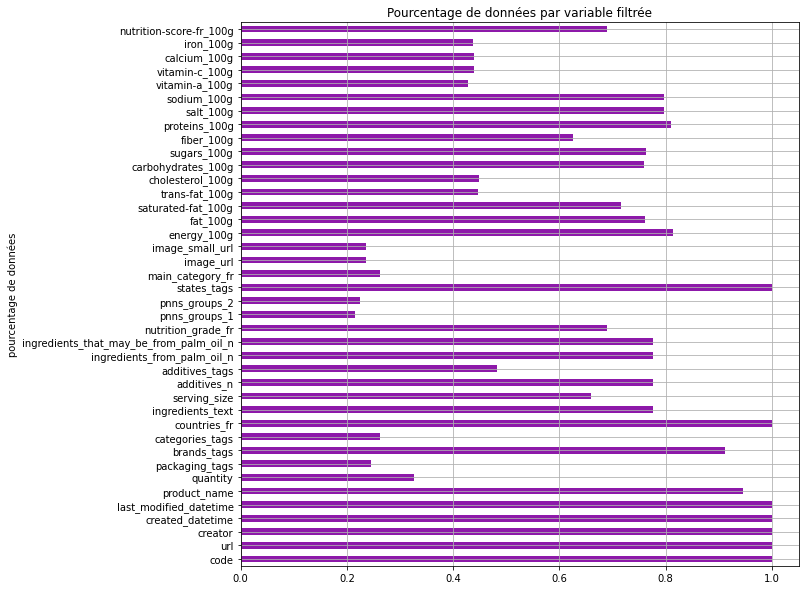

In [6]:
########################################################
#les dates
#colonnes redondantes avec des types mixtes, il faut retirer les strings qui ne sont pas des dates
#en passant au format date, on va forcer les exceptions de facons a les(les Strings) remplacer par des NaT
#on utilise la fonction pd.to_datetime avec le parametre errors='coerce'

data3.created_datetime= pd.to_datetime(data3.created_datetime,errors='coerce')
data3.last_modified_datetime= pd.to_datetime(data3.last_modified_datetime,errors='coerce')

#on supprime les colonnes
data4=data3.copy()
data4=data4.drop(columns=['created_t','last_modified_t'],axis=1)

########################################################
#on modifie quelques erreurs de syntaxe vues
data5=data4.copy()
data5.loc[:,['packaging_tags','brands_tags','product_name','pnns_groups_1','pnns_groups_2','main_category_fr']]=data5.loc[:,['packaging_tags','brands_tags','product_name','pnns_groups_1','pnns_groups_2','main_category_fr']].replace('-',' ')

data5['pnns_groups_1']=data5['pnns_groups_1'].str.replace('-',' ')

data5['packaging_tags']=data5['packaging_tags'].str.replace('-',' ')
data5['brands_tags']=data5['brands_tags'].str.replace('-',' ')
data5['product_name']=data5['product_name'].str.replace('-',' ')
data5['pnns_groups_1']=data5['pnns_groups_1'].str.replace('-',' ')
data5['pnns_groups_2']=data5['pnns_groups_2'].str.replace('-',' ')
data5['main_category_fr']=data5['main_category_fr'].str.replace('-',' ')

data5['packaging_tags']=data5['packaging_tags'].str.lower()
data5['brands_tags']=data5['brands_tags'].str.lower()
data5['product_name']=data5['product_name'].str.lower()
data5['pnns_groups_1']=data5['pnns_groups_1'].str.lower()
data5['pnns_groups_2']=data5['pnns_groups_2'].str.lower()
data5['main_category_fr']=data5['main_category_fr'].str.lower()

data5['packaging_tags']=data5['packaging_tags'].replace('n-a',np.nan)
data5['brands_tags']=data5['brands_tags'].replace('na',np.nan)
data5['pnns_groups_1']=data5['pnns_groups_1'].replace('unknown',np.nan)
data5['pnns_groups_2']=data5['pnns_groups_2'].replace('unknown',np.nan)
data5['main_category_fr']=data5['main_category_fr'].replace(r'[a-z|A-Z]{2}:','')
data5['pnns_groups_1']=data5['pnns_groups_1'].replace(r'[a-z|A-Z]{2}:','')
data5['pnns_groups_2']=data5['pnns_groups_2'].replace(r'[a-z|A-Z]{2}:','')

#display(data5['pnns_groups_1'].value_counts())

#on supprime les colonnes
data6=data5.copy()
data6=data6.drop(['packaging','brands','categories','categories_fr','countries','countries_tags','additives','additives_fr','states','states_fr','main_category','nutrition-score-uk_100g'],axis=1)

print('le fichier contient ', len(data6.columns),'colonnes aprés filtrage des variables' )

datanull3=1-(data6.isnull().sum()/len(data6.index))
plt.figure(figsize=(10,10))
ax = datanull3.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

### 1-E: Réduction du nombre de lignes
* Vision sous l'angle d'un seul pays suffisamment représenté: La france
* Suppression de la colonne pays et des variables peu représentées dans l'univers France
* Suppression des lignes:
    * sans données numériques de nutriment
    * sans caracteristique de nom de produit, ni de marque


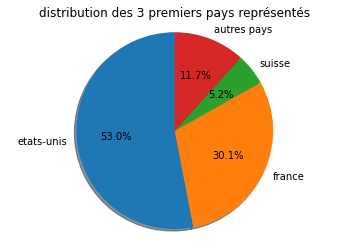

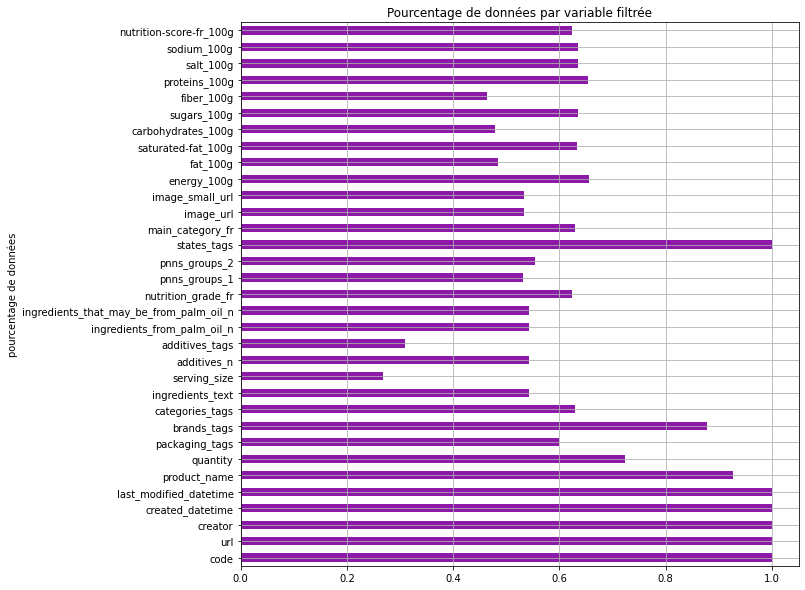

222309 lignes concernent des produits non vendus en France et peuvent etre oubliées
33136 lignes  n ont aucun élémént nutritif et peuvent etre oubliées
378 lignes supplémentaires n ont pas de nom de produit
273 lignes supplémentaires n ont pas de nom de marque
64653 lignes restantes et  33 colonnes aprés filtrage des variables peu représentéees dans l'univers France


In [7]:
#on met tous les pays en minuscules pour eviter les doubles noms / on enleve les accents 
data6.countries_fr=data6.countries_fr.astype(str).str.lower().str.replace('é','e')
#pd.set_option('display.max_rows', None)
#fonction split pour delister la string puis le stack pour empiler puis compter
temp=data6.countries_fr.str.split(',', expand=True).stack().value_counts()
temp=temp/temp.sum()
#display(temp.head(10))
#pd.set_option('display.max_rows', 10)

temp=temp.reset_index()
temp.columns=['countries','pct']
temp2=temp.head(3)
newrow={'countries':'autres pays','pct':1-(temp2.pct.sum())}
temp2=temp2.append(newrow,ignore_index=True)
temp2

labels = temp2['countries']
sizes = temp2['pct']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('distribution des 3 premiers pays représentés')
plt.show()

# on ne garde que les lignes vendues en france en comptant le nombre d'occurences , nous avons assez de données
data7=data6.copy()
data7=data7.loc[data7.countries_fr.str.count('france')>=1,:]
#display(data8.countries_fr)

#on retire la colonne pays qui ne sert plus a rien
data7=data7.drop(['countries_fr'],axis=1)

#filtre : on vire les variables avec moins de 20% de données
#pas de données dans certains cas peut vouloir dire donnée à 0 mais bon
datanull4=1-(data7.isnull().sum()/data7.shape[0])
datanull4=datanull4.reset_index()
datanull4.columns=['var','val']
listkeep=datanull4[datanull4['val']>=0.2]['var']

data7=data7[listkeep]
#print('le fichier contient ', len(data7.columns),'colonnes aprés filtrage des variables peu représentéees ' )

datanull5=1-(data7.isnull().sum()/len(data7.index))
plt.figure(figsize=(10,10))
ax = datanull5.plot.barh( color="#8d19a9",title='Pourcentage de données par variable filtrée', xlabel='pourcentage de données')
ax.grid(zorder=0)
plt.show()

print (data6.shape[0]-data7.shape[0], 'lignes concernent des produits non vendus en France et peuvent etre oubliées' )

########suppression des lignes sans données numériques
#on filtre sur les elements nutritifs qui ont un suffixe en _100g grace à la fonction filter
data8=data7[data7.filter(regex='_100g$',axis=1).isnull().apply(np.mean, axis=1)<1]
print (data7.shape[0]-data8.shape[0], 'lignes  n ont aucun élémént nutritif et peuvent etre oubliées' )
nbl=data8.shape[0]

data8=data8.loc[data8.product_name.notnull()]
print (nbl-data8.shape[0], 'lignes supplémentaires n ont pas de nom de produit' )
nbl=data8.shape[0]

data8=data8.loc[data8.brands_tags.notnull()]
print (nbl-data8.shape[0], 'lignes supplémentaires n ont pas de nom de marque' )
print (data8.shape[0], 'lignes restantes et ', len(data7.columns),"colonnes aprés filtrage des variables peu représentéees dans l'univers France")


### 1-F: Nettoyage des catégories
* 3 variables de catégories différentes sont disponibles:
    * main_category / pnns1 / pnns2
* Création d'un algorithme permettant de remplir les pnns manquants.
    * 600/700 observations vont être regagnées

In [8]:
print('')
print('CATEGORIES')
print('main_category_fr possède à ce stade du nettoyage ',data8.main_category_fr.value_counts().size,' catégories')
print('pnns_groups_1 possède à ce stade du nettoyage ',data8.pnns_groups_1.value_counts().size,' catégories')
print('pnns_groups_2 possède à ce stade du nettoyage ',data8.pnns_groups_2.value_counts().size,' catégories')
print('')
print('OBSERVATIONS VIDES PAR CATEGORIES')
print('main_category_fr possède à ce stade du nettoyage ',data8.main_category_fr.isnull().sum(),' lignes vides')
print('pnns_groups_1 possède à ce stade du nettoyage ',data8.pnns_groups_1.isnull().sum(),' lignes vides')
print('pnns_groups_2 possède à ce stade du nettoyage ',data8.pnns_groups_2.isnull().sum(),' lignes vides')

print(data8.loc[(data8.pnns_groups_1.isnull()) & (data8.pnns_groups_2.notnull())].shape[0],' lignes ont un pnns1 et pas de pnns2')
print(data8.loc[(data8.pnns_groups_1.notnull()) & (data8.pnns_groups_2.isnull())].shape[0],' lignes ont un pnns2 et pas de pnns1')



################################################
#algo permettant de retrouver group1 et group2 à partir de main catgeory
data9=data8.copy()
temp=data9.main_category_fr.value_counts().sort_values(ascending=False).reset_index()
temp.columns=['cat','nb']


j=0
for i in temp['cat']:
    mnb=int(temp.loc[temp['cat']==i]['nb'])
    j=j+1
    temp3=data9.loc[(data9.main_category_fr==i),'pnns_groups_2'].value_counts().sort_values(ascending=False).reset_index()
    temp3['pnns_groups_2_pct']=temp3.pnns_groups_2/temp3.pnns_groups_2.sum()
    temp3.columns=['cat2','nb','pct']
    temp4=data9.loc[(data9.main_category_fr==i),'pnns_groups_1'].value_counts().sort_values(ascending=False).reset_index()
    temp4['pnns_groups_1_pct']=temp4.pnns_groups_1/temp4.pnns_groups_1.sum()
    temp4.columns=['cat1','nb','pct']

    if temp3.shape[0]>0:
        g2nb=temp3.nb[0]
        if temp3.pct[0]>0.95:
            g2=temp3.cat2[0]
        else:
            g2='ni'
    else:
        g2=''
        g2nb=''
        
    if temp4.shape[0]>0:
        g1nb=temp4.nb[0]
        if temp4.pct[0]>0.95:
            g1=temp4.cat1[0]
        else:
            g1='ni'
    else:
        g1=''
        g1nb=''
        
    gi=[i,mnb,g2,g2nb,g1,g1nb]
    
    if j==1:
         gfull=[gi]
    else:
         gfull.append(gi)

tabcat=pd.DataFrame(gfull,columns=['main_category_fr','nb_main','pnns_groups_2','nb_g2','pnns_groups_1','nb_g1'])            
tabcat[['main_category_fr','pnns_groups_2','pnns_groups_1']] = tabcat[['main_category_fr','pnns_groups_2','pnns_groups_1']].astype('string')


################################################
#algo permettant de retrouver group1 à partir de group2

data9=data8.copy()
temp=data9.pnns_groups_2.value_counts().sort_values(ascending=False).reset_index()
temp.columns=['cat','nb']

j=0
for i in temp['cat']:
    mnb=int(temp.loc[temp['cat']==i]['nb'])
    j=j+1

    temp4=data9.loc[(data9.pnns_groups_2==i),'pnns_groups_1'].value_counts().sort_values(ascending=False).reset_index()
    temp4['pnns_groups_1_pct']=temp4.pnns_groups_1/temp4.pnns_groups_1.sum()
    temp4.columns=['cat1','nb','pct']

       
    if temp4.shape[0]>0:
        g1nb=temp4.nb[0]
        if temp4.pct[0]>0.95:
            g1=temp4.cat1[0]
        else:
            g1='ni'
    else:
        g1=''
        g1nb=''
        
    gi=[i,mnb,g1,g1nb]
    
    if j==1:
         gfull=[gi]
    else:
         gfull.append(gi)

tabcat2=pd.DataFrame(gfull,columns=['pnns_groups_2','nb_g2','pnns_groups_1','nb_g1'])            
tabcat2[['pnns_groups_2','pnns_groups_1']] = tabcat2[['pnns_groups_2','pnns_groups_1']].astype('string')
##################################################################################################

tabcat2.loc[tabcat2.pnns_groups_2=='tripe dishes','pnns_groups_1']='fish meat eggs'
tabcat2.loc[tabcat2.pnns_groups_2=='alcoholic beverages','pnns_groups_1']='beverages'

##################################################################################################
#renommage qui servira pour plus tard
tabcat2.loc[tabcat2.pnns_groups_1=='fruits and vegetables','pnns_groups_1_ren']='a fruits and vegetables'
tabcat2.loc[tabcat2.pnns_groups_1=='cereals and potatoes','pnns_groups_1_ren']='b cereals and potatoes'
tabcat2.loc[tabcat2.pnns_groups_1=='composite foods','pnns_groups_1_ren']='c composite foods'
tabcat2.loc[tabcat2.pnns_groups_1=='fish meat eggs','pnns_groups_1_ren']='d fish meat eggs'
tabcat2.loc[tabcat2.pnns_groups_1=='beverages','pnns_groups_1_ren']='e beverages'
tabcat2.loc[tabcat2.pnns_groups_1=='fat and sauces','pnns_groups_1_ren']='f fat and sauces'
tabcat2.loc[tabcat2.pnns_groups_1=='milk and dairy products','pnns_groups_1_ren']='g milk and dairy products'
tabcat2.loc[tabcat2.pnns_groups_1=='salty snacks','pnns_groups_1_ren']='h salty snacks'
tabcat2.loc[tabcat2.pnns_groups_1=='sugary snacks','pnns_groups_1_ren']='i sugary snacks'

tabcat2.loc[tabcat2.pnns_groups_1=='fruits and vegetables','pnns_groups_2_ren']='a fv '+tabcat2.loc[tabcat2.pnns_groups_1=='fruits and vegetables','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='cereals and potatoes','pnns_groups_2_ren']='b cp ' +tabcat2.loc[tabcat2.pnns_groups_1=='cereals and potatoes','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='composite foods','pnns_groups_2_ren']='c cf '+tabcat2.loc[tabcat2.pnns_groups_1=='composite foods','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='fish meat eggs','pnns_groups_2_ren']='d fme '+tabcat2.loc[tabcat2.pnns_groups_1=='fish meat eggs','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='beverages','pnns_groups_2_ren']='e bev '+tabcat2.loc[tabcat2.pnns_groups_1=='beverages','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='fat and sauces','pnns_groups_2_ren']='f fs '+tabcat2.loc[tabcat2.pnns_groups_1=='fat and sauces','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='milk and dairy products','pnns_groups_2_ren']='g mdp '+tabcat2.loc[tabcat2.pnns_groups_1=='milk and dairy products','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='salty snacks','pnns_groups_2_ren']='h sal '+tabcat2.loc[tabcat2.pnns_groups_1=='salty snacks','pnns_groups_2'].astype(str)
tabcat2.loc[tabcat2.pnns_groups_1=='sugary snacks','pnns_groups_2_ren']='i sug '+tabcat2.loc[tabcat2.pnns_groups_1=='sugary snacks','pnns_groups_2'].astype(str)

##################################################################################################
#on tente de remplir les trous


tabcatlight=tabcat.loc[(tabcat['pnns_groups_2']!='ni') & (tabcat['pnns_groups_2']!='')]
tabcat2light=tabcat2.loc[(tabcat2['pnns_groups_1']!='ni') & (tabcat2['pnns_groups_1']!='')]

#display(tabcatlight.main_category_fr)
#display(tabcat2light.pnns_groups_2)

#remplissage des group2 manquants
data9=data8.copy()
for i in tabcatlight.main_category_fr:
    #
    #
    #
    #important de mettre .item ou values[0] quand on va chercher un seul element
    data9.loc[((data9['main_category_fr']==i) & (data9['pnns_groups_2'].isnull())),'pnns_groups_2']=tabcatlight.loc[(tabcatlight['main_category_fr']==i),'pnns_groups_2'].item()

#remplissage des group1 manquants
for j in tabcat2light.pnns_groups_2:
    #important de mettre .item ou values[0] quand on va chercher un seul element
    data9.loc[((data9['pnns_groups_2']==j) & (data9['pnns_groups_1'].isnull())),'pnns_groups_1']=tabcat2light.loc[(tabcat2light['pnns_groups_2']==j),'pnns_groups_1'].item()

print('')
print('APRES REMPLISSAGE: OBSERVATIONS VIDES PAR CATEGORIES')    
print('main_category_fr possède toujours à ce stade du nettoyage ',data9.main_category_fr.isnull().sum(),' lignes vides')
print('pnns_groups_1 possède à ce stade du nettoyage ',data9.pnns_groups_1.isnull().sum(),' lignes vides')
print('pnns_groups_2 possède à ce stade du nettoyage ',data9.pnns_groups_2.isnull().sum(),' lignes vides')

print(data9.loc[(data9.pnns_groups_1.isnull()) & (data9.pnns_groups_2.notnull())].shape[0],' lignes ont un pnns2 et pas de pnns1')
print(data9.loc[(data9.pnns_groups_1.notnull()) & (data9.pnns_groups_2.isnull())].shape[0],' lignes ont un pnns1 et pas de pnns2')

#filtrage sur categories existantes
data9=data9.loc[(data9.pnns_groups_1.notnull()) | (data9.pnns_groups_2.notnull())]

print('')
print (data8.shape[0]-data9.shape[0], 'lignes supprimées aprés nettoyage des categories' )
print (data9.shape[0], 'lignes restantes' )

toto=tabcat2light.sort_values(by='pnns_groups_1_ren').reset_index()
display(toto.loc[:,['pnns_groups_1','pnns_groups_2','nb_g2']])


CATEGORIES
main_category_fr possède à ce stade du nettoyage  1103  catégories
pnns_groups_1 possède à ce stade du nettoyage  9  catégories
pnns_groups_2 possède à ce stade du nettoyage  36  catégories

OBSERVATIONS VIDES PAR CATEGORIES
main_category_fr possède à ce stade du nettoyage  16675  lignes vides
pnns_groups_1 possède à ce stade du nettoyage  21739  lignes vides
pnns_groups_2 possède à ce stade du nettoyage  21602  lignes vides
137  lignes ont un pnns1 et pas de pnns2
0  lignes ont un pnns2 et pas de pnns1

APRES REMPLISSAGE: OBSERVATIONS VIDES PAR CATEGORIES
main_category_fr possède toujours à ce stade du nettoyage  16675  lignes vides
pnns_groups_1 possède à ce stade du nettoyage  21021  lignes vides
pnns_groups_2 possède à ce stade du nettoyage  21021  lignes vides
0  lignes ont un pnns2 et pas de pnns1
0  lignes ont un pnns1 et pas de pnns2

21021 lignes supprimées aprés nettoyage des categories
43632 lignes restantes


,pnns_groups_1,pnns_groups_2,nb_g2
0,fruits and vegetables,fruits,1027
1,fruits and vegetables,dried fruits,308
2,fruits and vegetables,soups,391
3,fruits and vegetables,vegetables,1696
4,cereals and potatoes,potatoes,51
5,cereals and potatoes,cereals,2746
6,cereals and potatoes,legumes,457
7,cereals and potatoes,breakfast cereals,1044
8,cereals and potatoes,bread,1141
9,composite foods,pizza pies and quiche,416


### 1-G: Nettoyage de bon sens des données numériques
* Suppresion de lignes aux données aberrantes:
    * L'energie pour 100g ne peut etre superieur à 3700kj
    * Les valeurs nutritionnelles **ne peuvent être négatives** (sauf pour le nutriscore qui peut aller à -15)
    * Les valeurs nutritionnelles **ne peuvent depasser les 100g**
    * 100gr de sel doit représenter 38.8g de sodium 
    * les graisses saturées doivent etre inferieures en quantité aux graisses
    * le nutriscore doit etre compris **entre -15 et +40**


In [9]:
#stat descriptive
#display(data9.filter(regex='_100g$',axis=1).describe())
#ne pas oublier de faire la copie car si egal ca modifie toutes les tables
data10=data9.copy()
# on supprime les lignes dont l energie superieur à 3700kj (erreur de remplissage)
data10=data10.loc[(data10.energy_100g<=3700)]
print (data9.shape[0]-data10.shape[0], 'lignes supprimées aprés nettoyage energie_100g' )
temp=data10.shape[0]

# on supprime les lignes avec des valeurs negatives sauf le nutriscore qui peut aller à -15
data10.rename(columns = {'nutrition-score-fr_100g':'nutrition-score-fr'}, inplace = True)
data10=data10[data10.filter(regex='_100g$',axis=1).apply(np.min,axis=1)>=0]
data10.rename(columns = {'nutrition-score-fr':'nutrition-score-fr_100g'}, inplace = True)
print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage des valeurs negatives' )
temp=data10.shape[0]

# on supprime les valeurs dont au moins une valeur nutritionnelle > 100g
data10.rename(columns = {'energy_100g':'energy'}, inplace = True)
data10=data10[data10.filter(regex='_100g$',axis=1).apply(np.max,axis=1)<=100]
data10.rename(columns = {'energy':'energy_100g'}, inplace = True)
print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage des valeurs >100' )
temp=data10.shape[0]

# on supprime les valeurs ou le sodium > sel car 100g de sel=38.8g de sodium
data10=data10.loc[((data10.sodium_100g<data10.salt_100g) | (data10.sodium_100g.isnull()) | (data10.salt_100g.isnull()))]
data10=data10.loc[((data10.sodium_100g<=38.8) | (data10.sodium_100g.isnull()))]
print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage des valeurs sel/sodium' )
temp=data10.shape[0]

# on supprime les valeurs ou le saturated fat > fat (attention tiret du 6)
data10=data10.loc[((data10['saturated-fat_100g']<data10.fat_100g) | (data10['saturated-fat_100g'].isnull()) | (data10.fat_100g.isnull()))]

# on supprime les valeurs ou le transfat>2g : reco 1g)
#data10=data10.loc[((data10['trans-fat_100g']<=2) | (data10['trans-fat_100g'].isnull()))]
# on supprime les lignes dont le cholesterol est superieur à 3.1g (erreur de remplissage)
#data10=data10.loc[(data10.cholesterol_100g<=3.1) | data10.cholesterol_100g.isnull()]
print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage des fat/cholesterol' )
temp=data10.shape[0]                 
# on supprime les lignes dont la vitamine A est supérieur à 1g(11mg en fait)(erreur de remplissage)=> attention on peut perdre bcp de lignes à cause du probleme d echelle g/microg
#data10=data10.loc[(data10['vitamin-a_100g']<=1) | data10['vitamin-a_100g'].isnull()]
# on supprime les lignes dont la vitamine c est supérieur à 1g(erreur de remplissage)=> attention on peut perdre bcp de lignes à cause du probleme d echelle g/microg
#data10=data10.loc[(data10['vitamin-c_100g']<=1) | data10['vitamin-c_100g'].isnull()]
#print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage des vitamines' )
#temp=data10.shape[0]
# on supprime les lignes dont le calcium est supérieur à 2g(erreur de remplissage)=> attention on peut perdre bcp de lignes à cause du probleme d echelle g/microg
#data10=data10.loc[(data10.calcium_100g<=2) | data10.calcium_100g.isnull()]
#print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage du calcium' )
#temp=data10.shape[0]
# on supprime les lignes dont le fer est supérieur à 1g(erreur de remplissage)=> attention on peut perdre bcp de lignes à cause du probleme d echelle g/microg
#data10=data10.loc[(data10.iron_100g<=1) | data10.iron_100g.isnull()]
#print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage du fer' )
#temp=data10.shape[0]

# on supprime les lignes dont le nutriscore est inferieur à -15 ou > 40 
data10=data10.loc[(data10['nutrition-score-fr_100g']>=-15) & (data10['nutrition-score-fr_100g']<=40)]
print (temp-data10.shape[0], 'lignes supprimées aprés nettoyage du nutriscore' )
temp=data10.shape[0]

print (data9.shape[0]-data10.shape[0], 'lignes au total peuvent etre oubliées' )
print (data10.shape[0], 'lignes restantes' )

pd.set_option('display.max_columns', None)
#display(data10.filter(regex='_100g$',axis=1).describe())

729 lignes supprimées aprés nettoyage energie_100g
1 lignes supprimées aprés nettoyage des valeurs negatives
82 lignes supprimées aprés nettoyage des valeurs >100
3626 lignes supprimées aprés nettoyage des valeurs sel/sodium
2537 lignes supprimées aprés nettoyage des fat/cholesterol
2450 lignes supprimées aprés nettoyage du nutriscore
9425 lignes au total peuvent etre oubliées
34207 lignes restantes


### 1-H: Nettoyage des outliers des données numériques
* Filtre IQR 
    * filtre appliqué par catégorie pnns 2 afin d'etre plus fin
    * 1/3 des lignes sont retirées

In [10]:

#stat descriptive des nutriments filtré par categories

#calcul IQR par groupe 2
statdes=data10.groupby('pnns_groups_2').describe()
#display(statdes)

j=0
#boucle sur les nutriments: on recupere les iqr pour tous les groupes
for i in data10.filter(regex='_100g$',axis=1).columns.tolist():
    j=j+1
    cutlow=statdes[i,'50%']-1.5*(statdes[i,'75%']-statdes[i,'25%'])
    cutup=statdes[i,'50%']+1.5*(statdes[i,'75%']-statdes[i,'25%'])
    if (j==1):
        cl=cutlow
        cu=cutup
        #print(j)
    else:
        #concat des series
        cl=pd.concat([cl,cutlow],axis=1)
        cu=pd.concat([cu,cutup],axis=1)
        #print(j)
        
cl.columns=data10.filter(regex='_100g$',axis=1).columns.tolist()
cu.columns=data10.filter(regex='_100g$',axis=1).columns.tolist()

#on traite les données outliers : 2 possibilité: les capper ou les SUPPRIMER (juste l'observation ou la ligne entiere)
data11=data10.copy()
data11['flag_iqr']=0

#on met les noms des lignes et des colonnes dans une liste
#on boucle sur la liste des groupes 2 en i
for i in cu.index.tolist():
    for j in data11.filter(regex='_100g$',axis=1).columns.tolist():
        #seuil par groupe connu
        #data11.loc[(data11['pnns_groups_2']==i)&(data11[j]<cl.loc[i,j]),j]=cl.loc[i,j]
        #data11.loc[(data11['pnns_groups_2']==i)&(data11[j]>cu.loc[i,j]),j]=cu.loc[i,j]
        
        #on met le flag à 1 pour supprimer
        data11.loc[(data11['pnns_groups_2']==i)&(data11[j]<cl.loc[i,j]),'flag_iqr']=1
        data11.loc[(data11['pnns_groups_2']==i)&(data11[j]>cu.loc[i,j]),'flag_iqr']=1
        #seuil max pour les unknown
        ##data11.loc[(data9['pnns_groups_2'].isnull())&(data11[j]>cu[j].max()),j]=cu[j].max()
#suppresion
data11=data11.loc[data11.flag_iqr==0]
print (data10.shape[0]-data11.shape[0], 'lignes au total peuvent etre oubliées' )
print (data11.shape[0], 'lignes restantes' )

#on renomme pour ne pas prendre l energie qui n est pas sur la même echelle
#data11.rename(columns = {'energy_100g':'energy'}, inplace = True)

#import seaborn as sns
#plt.figure(figsize=(16, 6))
#ax=sns.boxplot(x="variable", y="value", data=pd.melt(data11.filter(regex='_100g$',axis=1)))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
#plt.show()

#data11.rename(columns = {'energy':'energy_100g'}, inplace = True)

13594 lignes au total peuvent etre oubliées
20613 lignes restantes


### 1-I: Passage du nombre d'additif en booléen (avec/sans)
* On simplifie la variable nombre d'additifs 


In [11]:
data11['addit']=np.sign(data11['additives_n'])

### 1-J: Suppression des variables sans interet pour notre analyse

In [12]:
data12=data11.copy()
listdrop=['url', 'creator', 'created_datetime', 'last_modified_datetime',
       'quantity', 'packaging_tags',
       'categories_tags', 'ingredients_text', 'serving_size', 'additives_n',
       'additives_tags', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n',
       'states_tags', 'main_category_fr',
       'image_url', 'image_small_url','flag_iqr']
data12=data12.drop(columns=listdrop)

### 1-J: Imputation des données quantitatives manquantes
* un bon tiers de la variable fibre , élément semblant important, n'est pas renseigné.
* Pour les analyses suivantes, de nombreuses techniques ne peuvent fonctionner avec des données manquantes comme l'**ACP**
* Nous allons faire appel a un **simple imputer** / median qui est plus rapide que le **KNN imputer**
    * ce dernier imputera par groupe pnns2 afin d'etre relativement fin

Pourcentage de valeurs manquantes avant/aprés imputation


,pct avant,pct aprés
code,%0.00,%0.00
product_name,%0.00,%0.00
brands_tags,%0.00,%0.00
nutrition_grade_fr,%0.00,%0.00
pnns_groups_1,%0.00,%0.00
pnns_groups_2,%0.00,%0.00
energy_100g,%0.00,%0.00
fat_100g,%5.46,%0.00
saturated-fat_100g,%0.00,%0.00
carbohydrates_100g,%5.62,%0.00


Résumé sur la table néttoyée:
20613  lignes / observations
17  colonnes / variables
3 variables descriptives: code - nom de produit - nom de marque
2 variables de catégories: pnns1 et pnns2
9 variables quantitatives de nutriments
1 variable booléenne: presence ou non  d'additif
1 variable quantitative de nutriscore
1 variable catégéorie de nutrigrade


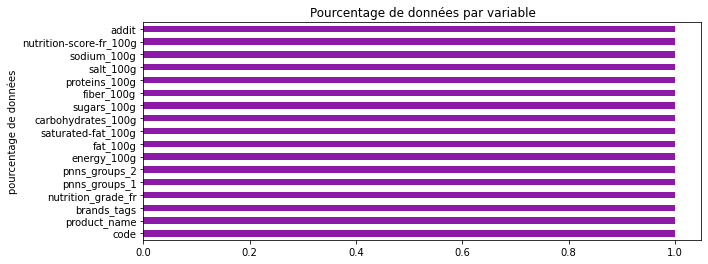

In [13]:
import numpy as np
from sklearn.impute import SimpleImputer

listfull=['code', 'product_name', 'brands_tags', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'addit']

listimput=['energy_100g', 'fat_100g','saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
           'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g','addit']

listnotimput=['code', 'product_name', 'brands_tags', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2']

#on reste l index pour retrouver l'ordre par la suite
temp=data12.copy().reset_index()

#on bouche les trous avec un imputer (simple de préférence-> moins long)
#initialisation de l imputer
imput_med = SimpleImputer(missing_values=np.nan, strategy='median')

#fit sur les données et transformation des données par groupe 2 et grade (variables de categories)
#attention à l imputer: il y a un defaut
#si les groupes sont trop fins, on peut avoir des colonnes vides et l imputer impuyissant dans ce cas les dropera , ce qui posera un problème
#donc on reste sur group2 plutot group2 et grade
i=0
for name,group in temp.groupby('pnns_groups_2'):
    #print(name)
    #print(group[j])
    i=i+1
        #imputer en action sur les colonnes numériques de la liste j
    grouptrans=pd.DataFrame(data=imput_med.fit_transform(group[listimput]))
    #print(imput_med.fit_transform(group[j]))
        #on remet l'index d'avant la transfo sinon ca rinitialise
    grouptrans.index=group[listimput].index
    grouptrans=pd.concat([group[listnotimput],grouptrans], axis=1)
    #display(grouptrans)
    grouptrans.columns=listfull
    if i==1:
        gt=grouptrans
    else:
        gt=pd.concat([gt,grouptrans], axis=0)
gt=gt.sort_index()
data13=gt.copy()
data13.loc[:,'addit']=np.sign(data13.loc[:,'addit'])
  
print('Pourcentage de valeurs manquantes avant/aprés imputation')

av=pd.DataFrame(data12.isnull().sum()/data12.shape[0]*100)
ap=pd.DataFrame(data13.isnull().sum()/data13.shape[0]*100)
mix=pd.concat([av,ap],axis=1)
mix.columns=['pct avant','pct aprés']

#formattage
import seaborn as sns
cm = sns.light_palette('purple', as_cmap=True)
display(mix.style.background_gradient(cm).format('%{:,.2f}'))

print('Résumé sur la table néttoyée:')
print(data13.shape[0],' lignes / observations')
print(data13.shape[1],' colonnes / variables')
print('3 variables descriptives: code - nom de produit - nom de marque')
print('2 variables de catégories: pnns1 et pnns2')
print('9 variables quantitatives de nutriments')
print("1 variable booléenne: presence ou non  d'additif")
print("1 variable quantitative de nutriscore")
print("1 variable catégéorie de nutrigrade")

datanull13=1-(data13.isnull().sum()/data13.shape[0])
plt.figure(figsize=(10,4))
ax = datanull13.plot.barh( color="#8d19a9",title='Pourcentage de données par variable', 
                                xlabel='pourcentage de données')


## STEP 2: ANALYSE STATISTIQUE
### 2-A: DESCRIPTIVE - Qantitative - Univariée
* Nous verifions que les actions de nettoyage ont porté leurs fruits
* les données quantitatives sont dans leur bornes

In [15]:
print('statistiques descriptives des données quantitatives')
pd.options.display.float_format = '{:,.2f}'.format
display(data13.describe())


#########VISUALISATION RAPIDE INTERACTIVE du BOXPLOT
    #init bouton widget

layout = widgets.Layout(width='auto', height='240px')
button1 = widgets.RadioButtons(value = 'energy_100g',
                               style={'description_width': 'initial'},
                               options = ['energy_100g', 'fat_100g','saturated-fat_100g',
                                          'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
                                          'proteins_100g', 'salt_100g', 'sodium_100g',
                                          'nutrition-score-fr_100g','addit'],
                               description = 'BoxPlot:VARIABLES',
                               layout=layout)
    #fonction s'affichage des données
    
def evaluate(a):
    #selection = button.get_interact_value()
    plt.rcParams["figure.figsize"] = [8, 3]
    sns.boxplot(x=a, data=data13)
    #axes[0].title.set_text('Relation nutrition grade et score par groupe pnns1')
    #axes[1].title.set_text('boxplot: Relation nutrition grade et score par groupe pnns1')
    plt.show()

    #affichage des widget avec evaluation
ui = widgets.VBox([button1])
out = widgets.interactive_output(evaluate, {'a': button1})
display(ui, out)

statistiques descriptives des données quantitatives


,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,addit
count,"20,613.00","20,613.00","20,613.00","20,613.00","20,613.00","20,613.00","20,613.00","20,613.00","20,613.00","20,613.00","20,613.00"
mean,"1,131.77",13.66,5.93,27.30,12.02,1.91,8.53,0.80,0.31,8.37,0.63
std,752.07,14.90,8.42,27.11,16.55,2.01,7.12,0.73,0.29,9.26,0.48
min,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-12.00,0.00
25%,448.00,2.00,0.50,3.00,0.80,0.20,3.30,0.13,0.05,1.00,0.00
50%,"1,055.00",7.40,2.30,13.70,3.50,1.50,6.60,0.70,0.28,7.00,1.00
75%,"1,730.00",23.50,9.00,54.00,18.00,2.90,11.80,1.20,0.47,16.00,1.00
max,"3,700.00",100.00,70.00,93.00,77.40,15.20,33.00,4.61,1.81,29.00,1.00


Output()

### 2-B:DESCRIPTIVE -  Catégories - Univariée
* Toutes les 5 catégories du nutrigrade sont bien représentées:
    * les **meilleurs grades a et b** sont legerement moins bien représentés que les mauvais grades d,c,e
* Toutes les 9 catégories du PNNS groupe 1 sont également bien représentés:
    * **les sucreries représentent 20%** des données alors que les snacks salés, les boissons, le gras et sauces ainsi que **les fruits et legumes ne représentent chacun que 5%** des données
* Concernant les 36  catégories du PNNS groupe 2:
    * les **gateaux/biscuits ainsi que les plats cuisinés** représentent à eux 2 **20%** des données.
* Concernant les 3600 marques, les marques des hypermarchés sont le mieux représentées. Mais c'est une variable avec trop de modalité qui ne nous apportera pas d'information utile

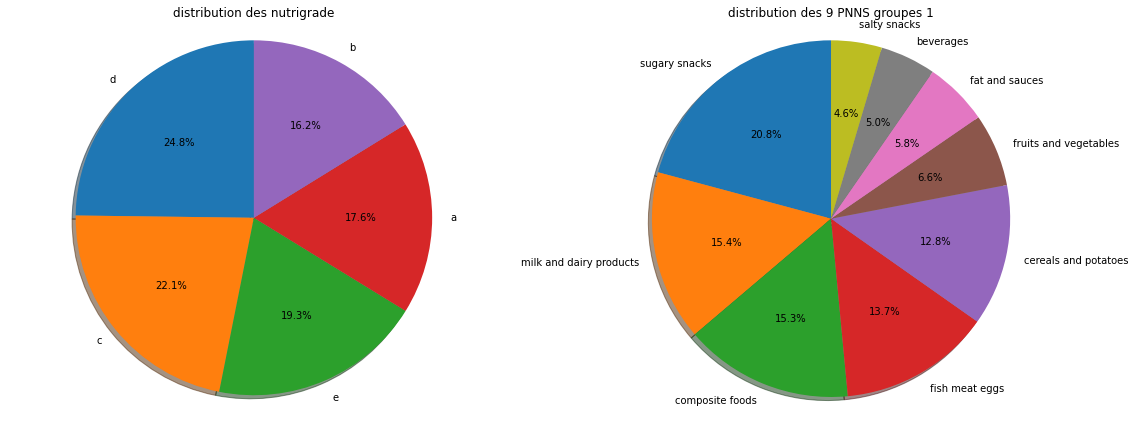

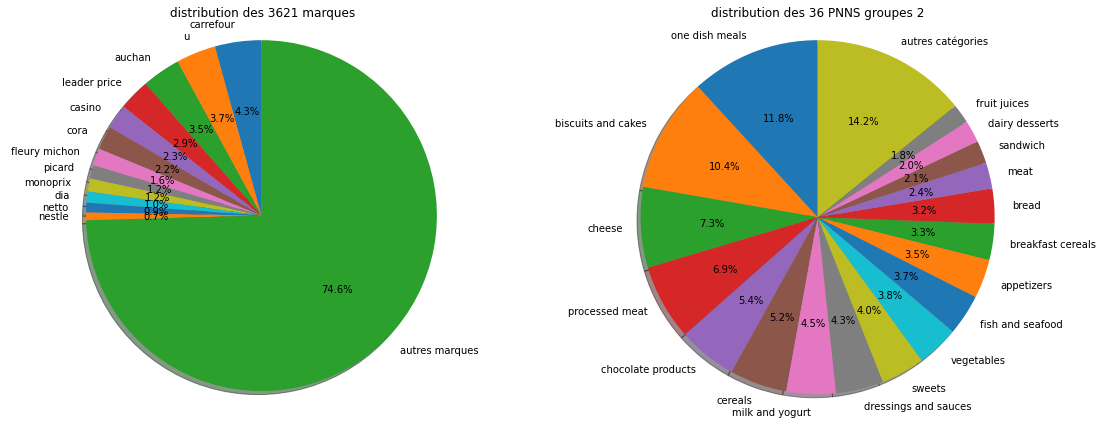

In [16]:
plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(1, 2)
axes[0].pie(data13['nutrition_grade_fr'].value_counts()/data13['nutrition_grade_fr'].value_counts().sum(),
        labels=data13['nutrition_grade_fr'].value_counts().index,
        autopct='%1.1f%%',shadow=True, startangle=90, normalize=False)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title('distribution des nutrigrade')


axes[1].pie(data13['pnns_groups_1'].value_counts()/data13['pnns_groups_1'].value_counts().sum(),
        labels=data13['pnns_groups_1'].value_counts().index,
        autopct='%1.1f%%',shadow=True, startangle=90, normalize=False)
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].set_title('distribution des '+str(data13['pnns_groups_1'].value_counts().shape[0])+' PNNS groupes 1')

plt.show()

temp=data13.brands_tags.value_counts()/data13.brands_tags.value_counts().sum()
temp=temp.reset_index()
temp.columns=['brands_tags','pct']
temp2=temp.head(12)
newrow={'brands_tags':'autres marques','pct':1-(temp2.pct.sum())}
temp2=temp2.append(newrow,ignore_index=True)
temp2

labels = temp2['brands_tags']
sizes = temp2['pct']

f, axes = plt.subplots(1, 2)
axes[0].pie(temp2['pct'],
        labels=temp2['brands_tags'],
        autopct='%1.1f%%',shadow=True, startangle=90, normalize=False)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title('distribution des '+str(temp.shape[0])+' marques')

temp=data13.pnns_groups_2.value_counts()/data13.pnns_groups_2.value_counts().sum()
temp=temp.reset_index()
temp.columns=['pnns_groups_2','pct']
temp2=temp.head(18)
newrow={'pnns_groups_2':'autres catégories','pct':1-(temp2.pct.sum())}
temp2=temp2.append(newrow,ignore_index=True)
temp2

labels = temp2['pnns_groups_2']
sizes = temp2['pct']

axes[1].pie(temp2['pct'],
        labels=temp2['pnns_groups_2'],
        autopct='%1.1f%%',shadow=True, startangle=90, normalize=False)
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].set_title('distribution des '+str(temp.shape[0])+' PNNS groupes 2')

plt.show()

### 2-C:DESCRIPTIVE -  Bivariée
#### 2-C-1: Relation visuelle claire entre nutrigrade et nutriscore
* chaque grade correspond à un intervalle de nutriscore
    * les scores les moins élevés correspondent aux meilleurs grades alors que les scores les plus élevées correspondent aux moins bons grades

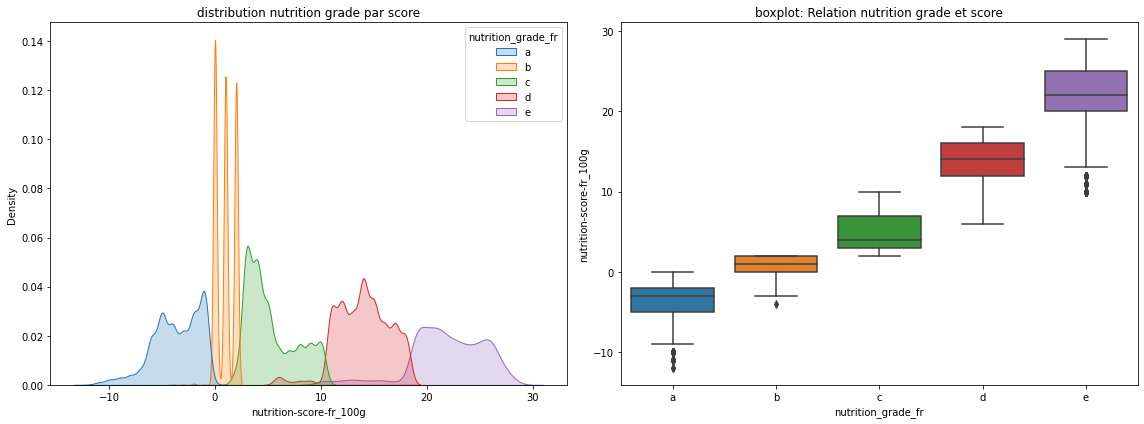

statistique descriptive des grades/scores


nutrition-score-fr_100g                                \
                                     count  mean  std    min   25%   50%   
nutrition_grade_fr                                                         
a                                 3,632.00 -3.65 2.25 -12.00 -5.00 -3.00   
b                                 3,334.00  0.95 0.84  -4.00  0.00  1.00   
c                                 4,552.00  5.29 2.36   2.00  3.00  4.00   
d                                 5,111.00 13.96 2.48   6.00 12.00 14.00   
e                                 3,984.00 21.89 3.53  10.00 20.00 22.00   

                                
                     75%   max  
nutrition_grade_fr              
a                  -2.00  0.00  
b                   2.00  2.00  
c                   7.00 10.00  
d                  16.00 18.00  
e                  25.00 29.00

In [17]:
temp=data13.loc[:,['nutrition-score-fr_100g','nutrition_grade_fr','pnns_groups_1','pnns_groups_2']].sort_values(by=['nutrition_grade_fr','pnns_groups_1','pnns_groups_2'])

plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(1, 2)

sns.kdeplot(x='nutrition-score-fr_100g', hue='nutrition_grade_fr', fill=True,data=temp,ax=axes[0])
#sns.stripplot(x='nutrition_grade_fr', y='nutrition-score-fr_100g', data=temp,ax=axes[0])
sns.boxplot(x='nutrition_grade_fr', y='nutrition-score-fr_100g', data=temp,ax=axes[1])

axes[0].title.set_text('distribution nutrition grade par score')
axes[1].title.set_text('boxplot: Relation nutrition grade et score')
plt.show()

#######################################################
print('statistique descriptive des grades/scores')
pd.options.display.float_format = '{:,.2f}'.format
display(data13.loc[:,['nutrition-score-fr_100g','nutrition_grade_fr']].groupby('nutrition_grade_fr').describe())

#### 2-C-2: Relation entre nutrigrade et nutriscore : ventilation par PNNS groupe 1
* on s'apercoit d'une relation grade/score legerement différente par catégories
    * la relation ne semble pas avoir exactement les mêmes intervalles de score pour les boissons
* Les fruits et legumes n'ont pas de mauvais grades d et e comme on peut s'en douter
* Les sucreries et snacks salés n'ont pas de bons grades a et b

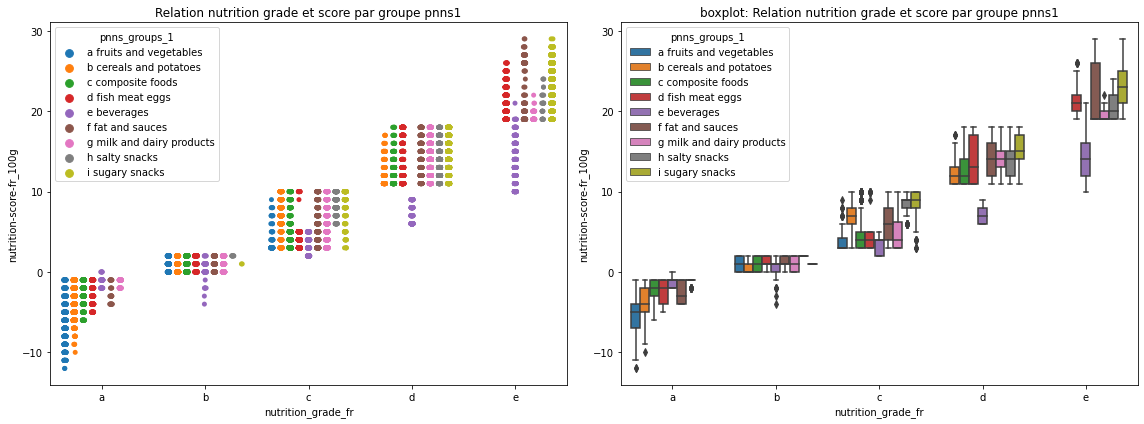

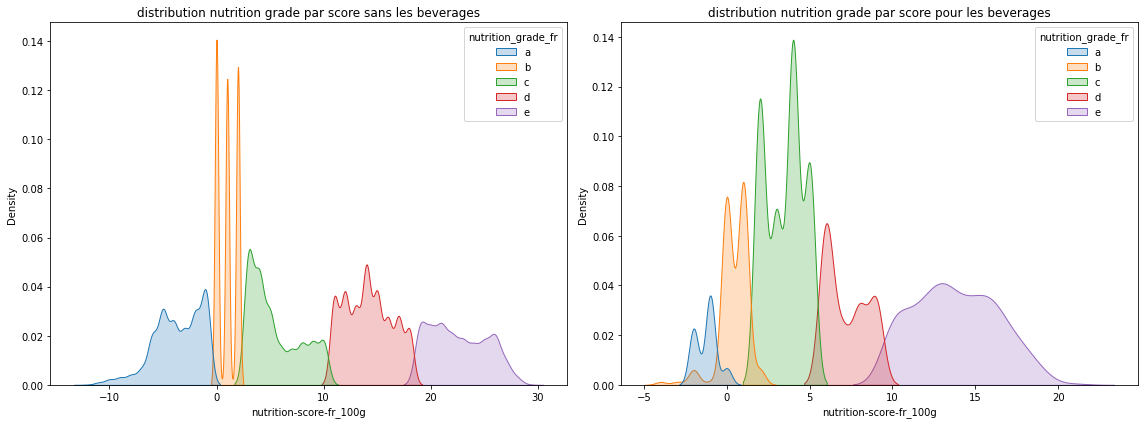

nutrition-score-fr_100g 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 nutrition_grade_fr 
 
 
 
 
 
 
 
 
 
 
 
 
 a 
 3,583.00 
 -3.69 
 2.25 
 -12.00 
 -5.00 
 -4.00 
 -2.00 
 -1.00 
 
 
 b 
 3,190.00 
 0.97 
 0.83 
 0.00 
 0.00 
 1.00 
 2.00 
 2.00 
 
 
 c 
 4,190.00 
 5.45 
 2.37 
 3.00 
 3.00 
 5.00 
 7.00 
 10.00 
 
 
 d 
 4,945.00 
 14.19 
 2.17 
 11.00 
 12.00 
 14.00 
 16.00 
 18.00 
 
 
 e 
 3,669.00 
 22.59 
 2.63 
 19.00 
 20.00 
 22.00 
 25.00 
 29.00 
 
 
 
 
 
 
 nutrition-score-fr_100g 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 nutrition_grade_fr 
 
 
 
 
 
 
 
 
 
 
 
 
 a 
 49.00 
 -1.24 
 0.63 
 -2.00 
 -2.00 
 -1.00 
 -1.00 
 0.00 
 
 
 b 
 144.00 
 0.42 
 0.87 
 -4.00 
 0.00 
 1.00 
 1.00 
 2.00 
 
 
 c 
 362.00 
 3.49 
 1.12 
 2.00 
 2.00 
 4.00 
 4.00 
 5.00 
 
 
 d 
 166.00 
 7.22 
 1.23 
 6.00 
 6.00 
 7.00 
 8.00 
 9.00 
 
 
 e 
 315.00 
 13.80 
 2.51 
 10.00 
 12.00 
 14.00 
 16.00 
 21.00

In [18]:
#on va renommer temp grace à tabcat2 pour plus de lisibilité
#tabcat2 est un précedent tableau de relation entre les groupes 1 et 2
temp=data13.loc[:,['nutrition-score-fr_100g','nutrition_grade_fr','pnns_groups_1','pnns_groups_2']].sort_values(by=['nutrition_grade_fr','pnns_groups_1','pnns_groups_2'])

temp2=temp['pnns_groups_1'].value_counts().reset_index()
lis1=temp2['index'].tolist()
temp2=temp['pnns_groups_2'].value_counts().reset_index()
lis2=temp2['index'].tolist()

for i in lis1:
    temp.loc[temp.pnns_groups_1==i,'pnns_groups_1']=tabcat2.loc[tabcat2.pnns_groups_1==i,'pnns_groups_1_ren'].reset_index().iloc[0,1]
for i in lis2:
    temp.loc[temp.pnns_groups_2==i,'pnns_groups_2']=tabcat2.loc[tabcat2.pnns_groups_2==i,'pnns_groups_2_ren'].reset_index().iloc[0,1]

f, axes = plt.subplots(1, 2)

temp=temp.sort_values(by=['pnns_groups_1','nutrition_grade_fr'])

sns.stripplot(x='nutrition_grade_fr', y='nutrition-score-fr_100g',hue='pnns_groups_1', data=temp,ax=axes[0],dodge=True)
sns.boxplot(x='nutrition_grade_fr', y='nutrition-score-fr_100g',hue='pnns_groups_1', data=temp,ax=axes[1],dodge=True)

axes[0].title.set_text('Relation nutrition grade et score par groupe pnns1')
axes[1].title.set_text('boxplot: Relation nutrition grade et score par groupe pnns1')
plt.show()

#######################################################

f, axes = plt.subplots(1, 2)

sns.kdeplot(x='nutrition-score-fr_100g', hue='nutrition_grade_fr', fill=True,data=temp.loc[temp['pnns_groups_1']!='e beverages'],ax=axes[0])
sns.kdeplot(x='nutrition-score-fr_100g', hue='nutrition_grade_fr', fill=True,data=temp.loc[temp['pnns_groups_1']=='e beverages'].sort_values(by='nutrition_grade_fr'),ax=axes[1])

axes[0].title.set_text('distribution nutrition grade par score sans les beverages')
axes[1].title.set_text('distribution nutrition grade par score pour les beverages')
plt.show()

#######################################################
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
tempa=temp.loc[(temp['pnns_groups_1']!='e beverages'),['nutrition-score-fr_100g','nutrition_grade_fr']].groupby('nutrition_grade_fr').describe()
tempb=temp.loc[(temp['pnns_groups_1']=='e beverages'),['nutrition-score-fr_100g','nutrition_grade_fr']].groupby('nutrition_grade_fr').describe()

pd.options.display.float_format = '{:,.2f}'.format
display_side_by_side(tempa,tempb)

#### 2-C-3: Relation entre pnns groupe 1 et nutrigrade/nutriscore
* Une relation existe entre nutri score et catégorie de produit
    * les fruits et legumes , les céréales ont les nutriscores les plus faibles donc les meilleurs grades
        * les fruits et légumes ne sont pas représentés dans les moins bons grades 
    * à l'opposé les sucreries sont trés mal placées
        * les sucreries et les snacks salés ne sont pas représentés dans les meilleures nutrigrades a/b

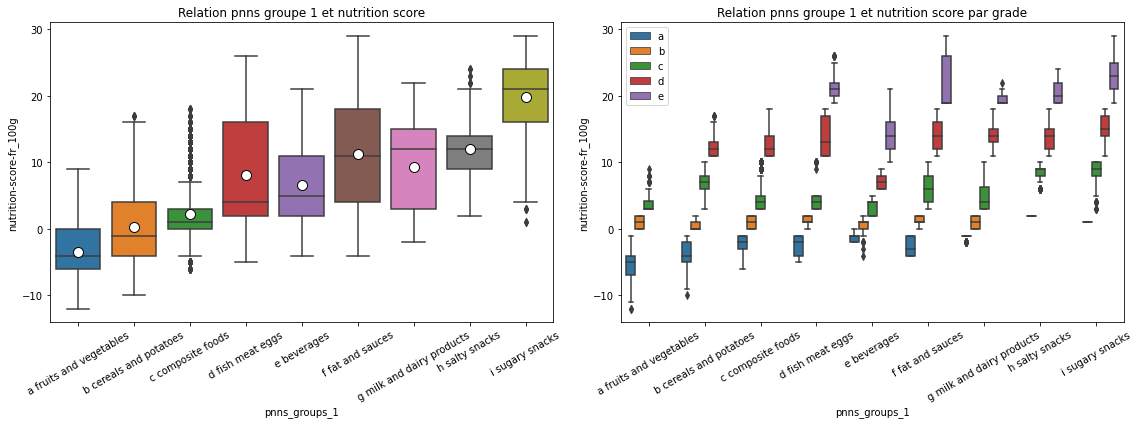

In [19]:
f, axes = plt.subplots(1, 2)

sns.boxplot(x='pnns_groups_1', y='nutrition-score-fr_100g', data=temp,ax=axes[0],showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
sns.boxplot(x='pnns_groups_1', y='nutrition-score-fr_100g',hue='nutrition_grade_fr', data=temp,ax=axes[1])


axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=30)
axes[0].title.set_text('Relation pnns groupe 1 et nutrition score')

axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=30)
axes[1].title.set_text('Relation pnns groupe 1 et nutrition score par grade')
plt.legend(loc='upper left')


plt.show()

#### 2-C-4: Relation entre pnns groupe 2 et nutriscore
* Ce qui est vrai pour le Pnns groupe 1 l'est également pour le Pnns groupe 2 qui constitue un découpage plus fin

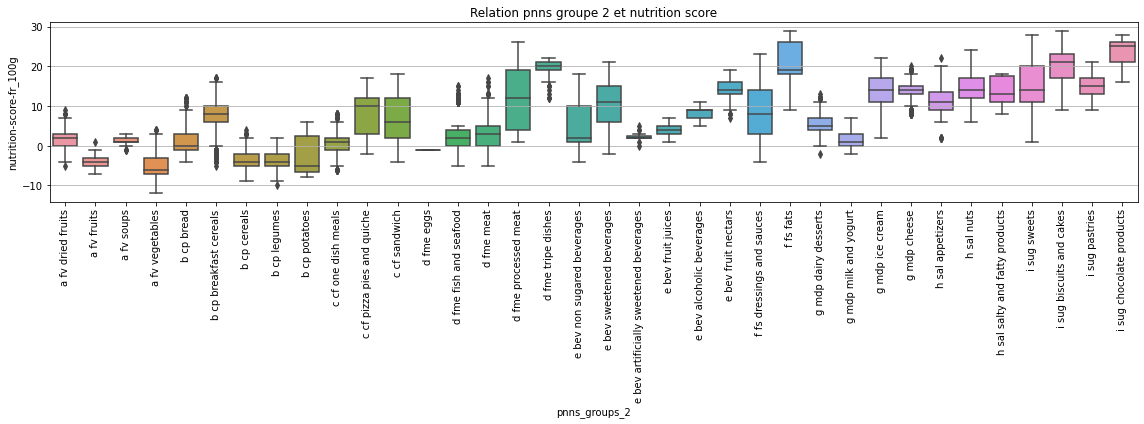

In [20]:
ax=sns.boxplot(x='pnns_groups_2', y='nutrition-score-fr_100g', data=temp)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('Relation pnns groupe 2 et nutrition score')
ax.xaxis.grid(False)
ax.yaxis.grid(True)

plt.show()

#### 2-C-5: Relation entre additifs et nutrigrade
* on observe une relation entre la présence ou non d'additif avec le nutri score et le nutri grade.
    * les produits du grade e ont en trés grande majorité des additifs .
    * le groupe a possède la plus faible proportion de présence d'additif. Cette proportion moyenne augmente avec les grades

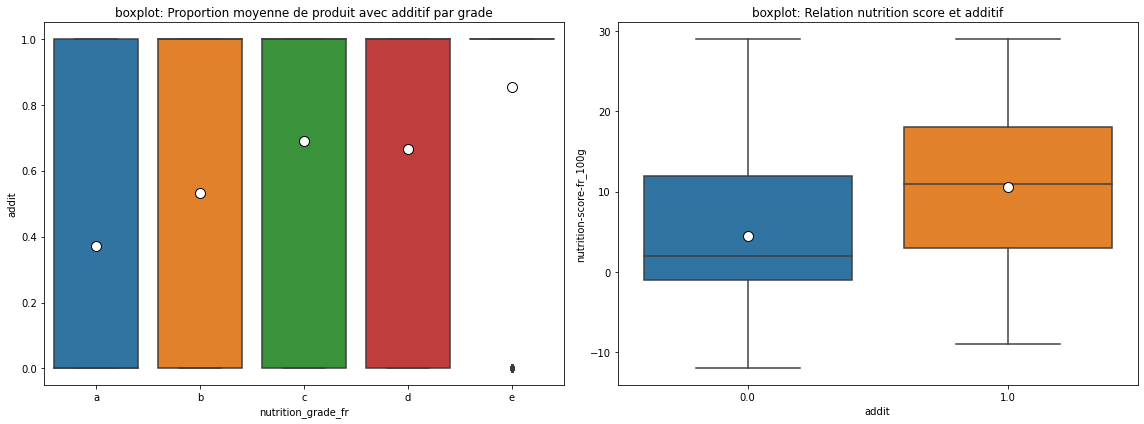

In [21]:
temp=data13.loc[:,['nutrition-score-fr_100g','nutrition_grade_fr','addit']].sort_values(by=['nutrition_grade_fr'])

plt.rcParams["figure.figsize"] = [16, 6]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(1, 2)

sns.boxplot(x='nutrition_grade_fr', y='addit', data=temp,ax=axes[0],
           showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
#sns.stripplot(x='nutrition_grade_fr', y='nutrition-score-fr_100g', data=temp,ax=axes[0])
sns.boxplot(x='addit', y='nutrition-score-fr_100g', data=temp,ax=axes[1],
           showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})

axes[0].title.set_text('boxplot: Proportion moyenne de produit avec additif par grade')
axes[1].title.set_text('boxplot: Relation nutrition score et additif')
plt.show()

#### 2-C-5: Relation entre données quantitatives nutritionnelles et nutriscore
##### 2-C-5-A: Nuages de points bivariés
* Quelques relations qu'on devine visuellement

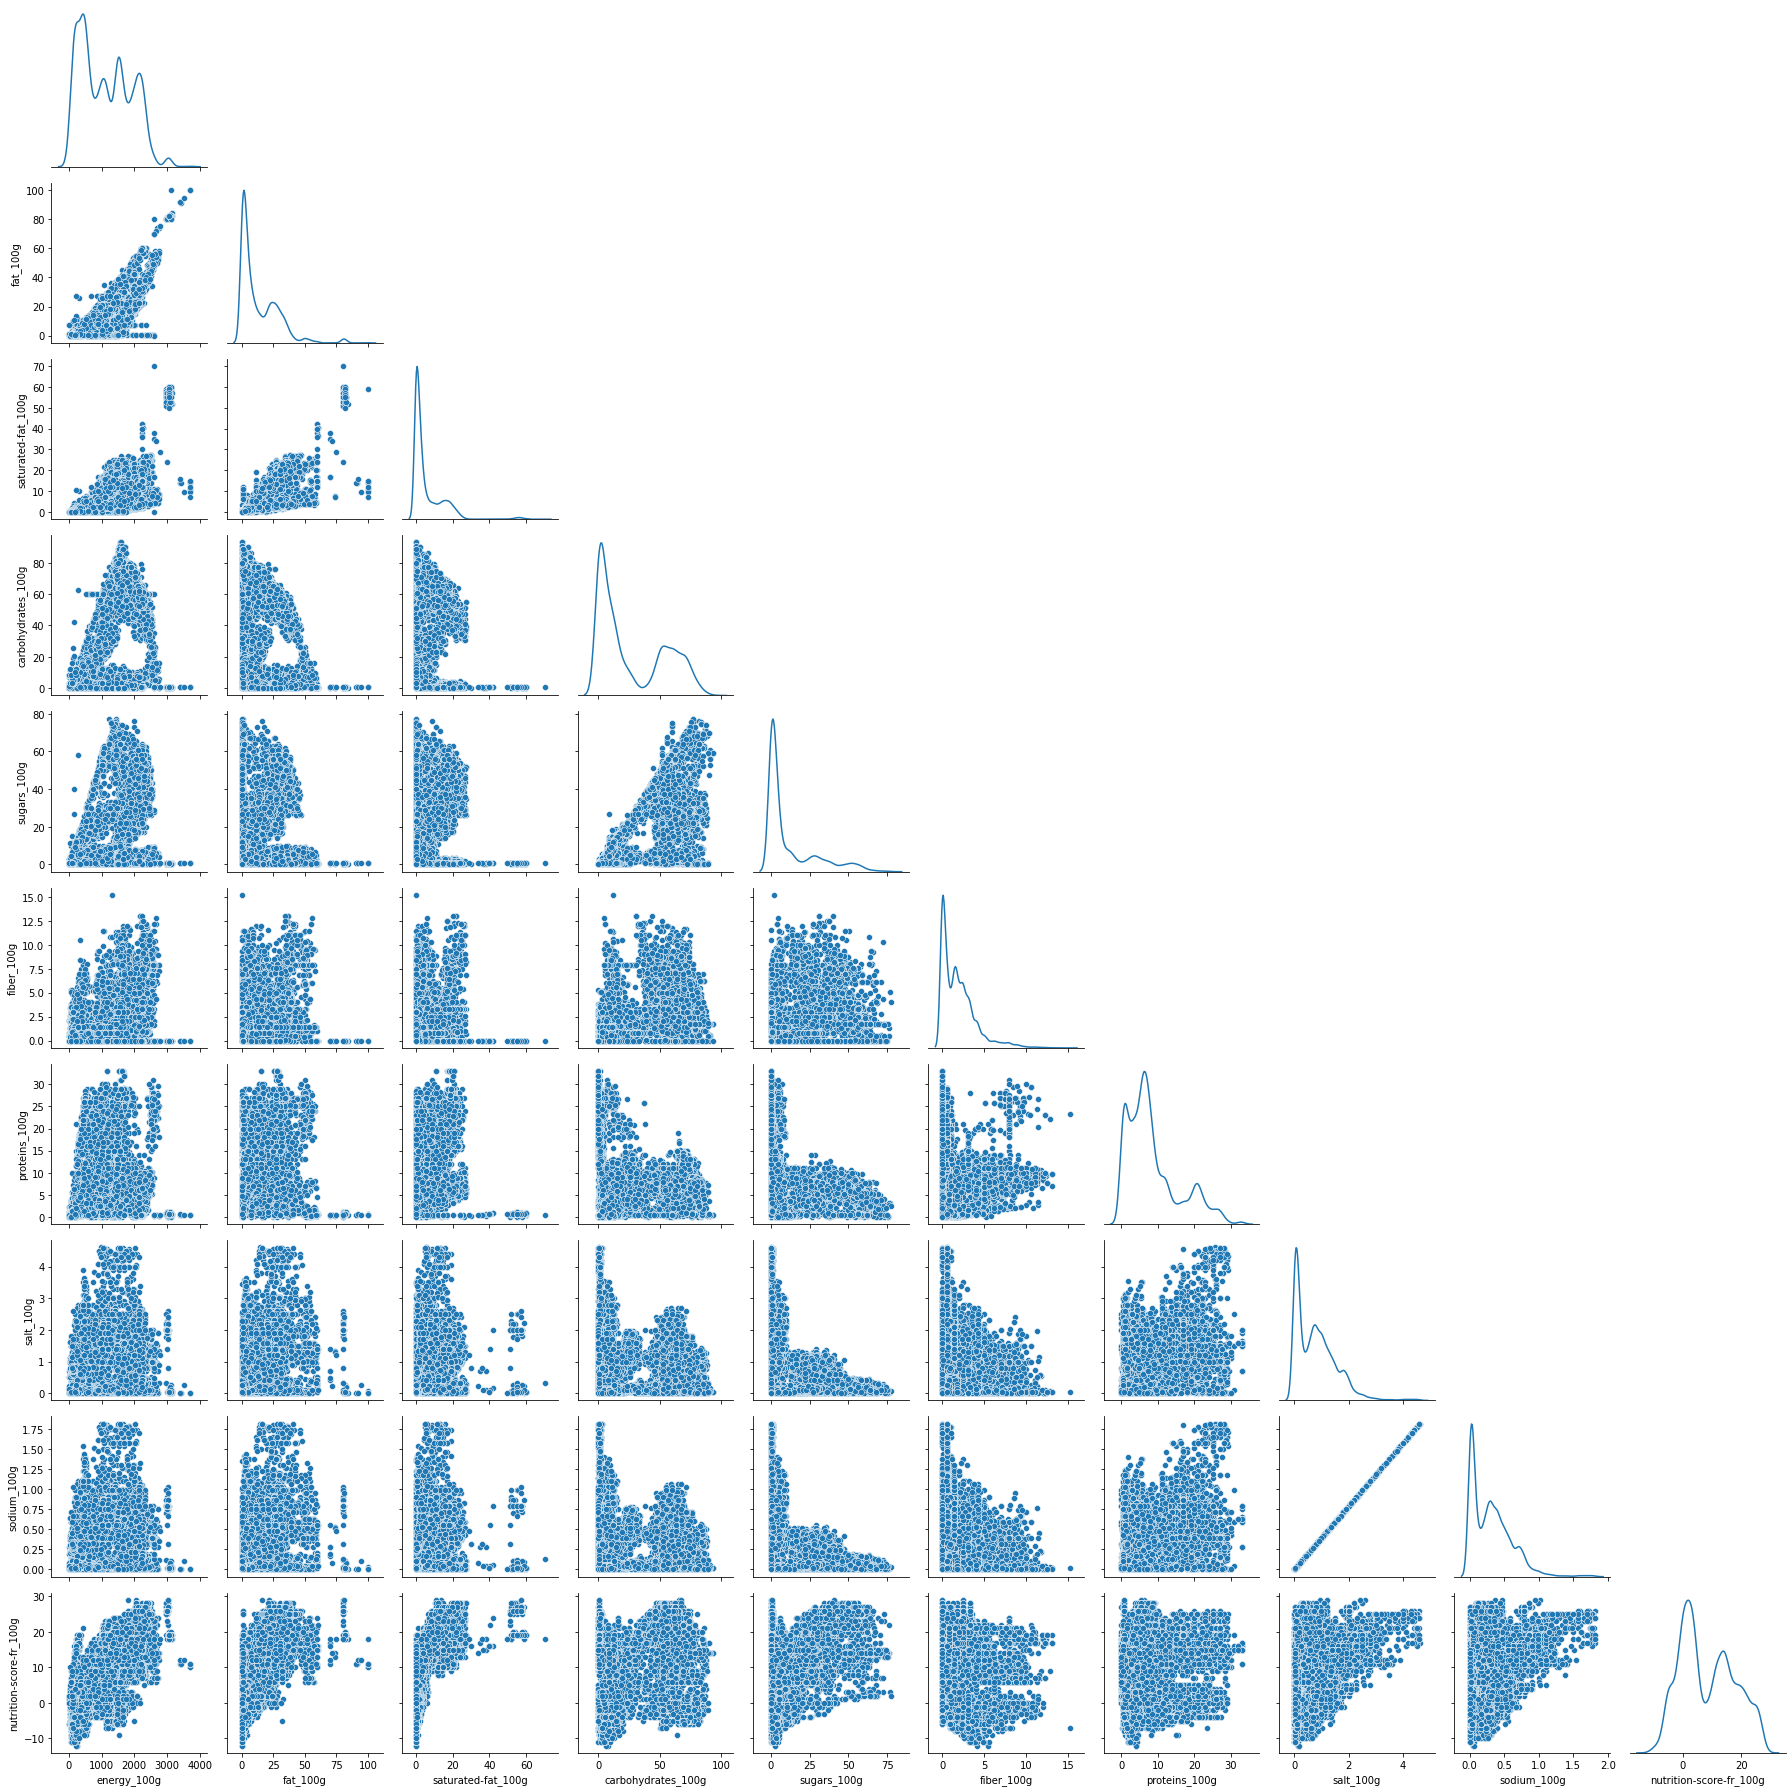

In [22]:
j=data13.filter(regex='_100g$',axis=1).columns.tolist()
temp=data13.loc[:,j]

g = sns.PairGrid(temp, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

#### 2-C-5: Relation entre données quantitatives nutritionnelles et nutriscore
##### 2-C-5-B: Relation lineaire ? - corrélation de Pearson
* Des correlations de **pearson** significatives
    * correlation positive avec le nutriscore :
        * energy
        * gras
        * sucre
    * correlation positive entre gras et energie
    * correlation positive entre proteine et sel
    * correlation positive entre sucre et hydrates de carbone
    * correlation positive entre fibre et hydrates de carbone
    * correlation négative entre sucre et sel
    * correlation parfait entre sel et sodium
* Mais l'hypothèse de normalité non respectée ne permet pas de valider les résultats de relation de linearité

C:\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<Figure size 1152x576 with 0 Axes>

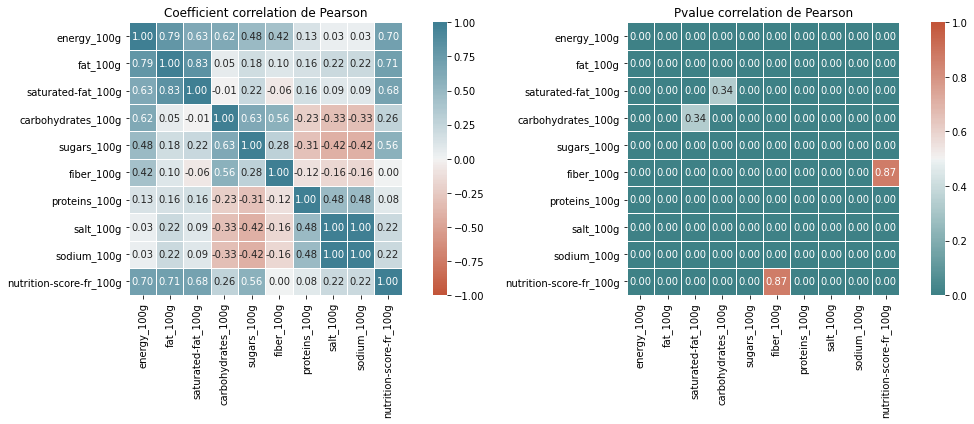

<Figure size 1152x576 with 0 Axes>

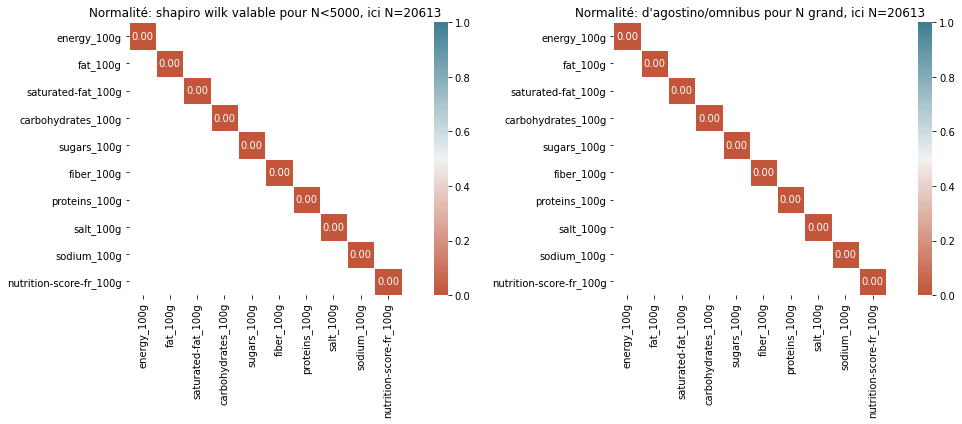

In [23]:
###############################################################
#Correlation: relations lineaires
j=data13.filter(regex='_100g$',axis=1).columns.tolist()
temp=data13.loc[:,j]

from scipy.stats import pearsonr
from scipy.stats import spearmanr
#normalité
from scipy.stats import shapiro
from scipy.stats import normaltest

#https://towardsdatascience.com/pearson-coefficient-of-correlation-explained-369991d93404
def calculate_corr(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pearscoeff = dfcols.transpose().join(dfcols, how='outer')
    pearspvalues = pearscoeff.copy()
    shappvalues = pearscoeff.copy()
    normpvalues = pearscoeff.copy()
    spearcoeff = pearscoeff.copy()
    spearpvalues = pearscoeff.copy()
    for r in df.columns:
        for c in df.columns:
            pearscoeff[r][c] = round(pearsonr(df[r], df[c])[0], 4)
            pearspvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            spearcoeff[r][c] = round(spearmanr(df[r], df[c])[0], 4)
            spearpvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            if r==c:
                #attention pvalue shapiro wilk seulement pour N<5000
                shappvalues[r][c] = round(shapiro(df[r])[1], 4)
                #d'agostino basé sur omnibus plus adapté pour les grands echantillons
                normpvalues[r][c] = round(normaltest(df[r])[1], 4)
    pearscoeff[df.columns] = pearscoeff[df.columns].astype(float)        
    pearspvalues[df.columns] = pearspvalues[df.columns].astype(float)
    shappvalues[df.columns] = shappvalues[df.columns].astype(float)
    normpvalues[df.columns] = normpvalues[df.columns].astype(float)
    spearcoeff[df.columns] = spearcoeff[df.columns].astype(float)        
    spearpvalues[df.columns] = spearpvalues[df.columns].astype(float)
    return pearscoeff,pearspvalues,shappvalues,normpvalues,spearcoeff,spearpvalues

cocorr,pvcorr,shap,dagos,cospcorr,pvspcorr=calculate_corr(temp)

plt.figure(figsize=(16,8))
f, axes = plt.subplots(1, 2)

sns.heatmap(
    cocorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,ax=axes[0])
axes[0].title.set_text('Coefficient correlation de Pearson')

sns.heatmap(
    pvcorr, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(200, 20, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,ax=axes[1])
axes[1].title.set_text('Pvalue correlation de Pearson')

plt.show()

plt.figure(figsize=(16,8))
f, axes = plt.subplots(1, 2)

sns.heatmap(
    shap, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,ax=axes[0])
axes[0].title.set_text('Normalité: shapiro wilk valable pour N<5000, ici N='+str(temp.shape[0]))

sns.heatmap(
    dagos, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,ax=axes[1])
axes[1].title.set_text("Normalité: d'agostino/omnibus pour N grand, ici N="+str(temp.shape[0]))

plt.show()



#### 2-C-5: Relation entre données quantitatives nutritionnelles et nutriscore
##### 2-C-5-C: Relation monotone non paramétrique ? - corrélation de Spearman
* Corrélation de rang de spearman
    * les relations précédemment décrites mais monotones, cette fois ci, sont significatives

<Figure size 1152x576 with 0 Axes>

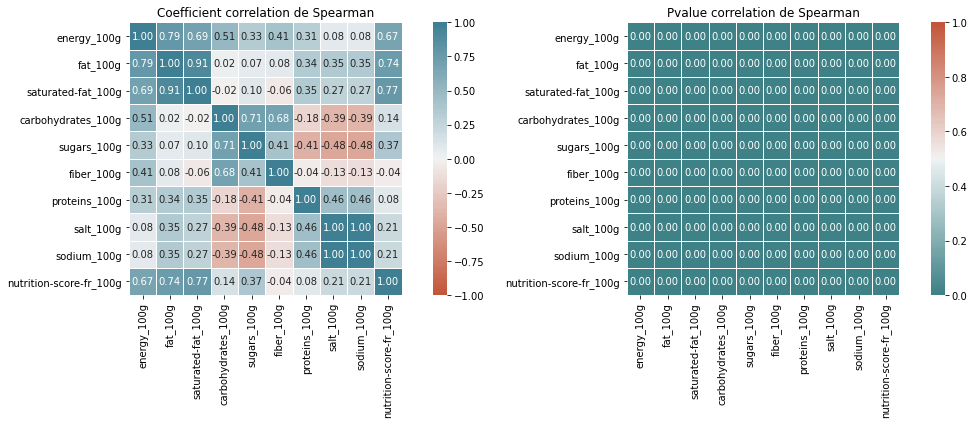

In [24]:
plt.figure(figsize=(16,8))
f, axes = plt.subplots(1, 2)

sns.heatmap(
    cospcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,ax=axes[0])
axes[0].title.set_text('Coefficient correlation de Spearman')

sns.heatmap(
    pvspcorr, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(200, 20, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,ax=axes[1])
axes[1].title.set_text('Pvalue correlation de Spearman')

plt.show()

### 2-D:DESCRIPTIVE / EXPLICATIVE -  Multivariée
* On peut identifier deux grandes familles de méthode d'analyse mutlivariée
    * **les méthodes descriptives** 
        * visant à structurer et résumer l'information:
            * ACP, AFC-ACM, analyse factorielle, clustering, MDS (positionnement multidimensionnel)
    * **les méthodes explicatives** 
        * visant à expliquer une ou des variables dites « dépendantes » (variables à expliquer) par un ensemble de variables dites « indépendantes » (variables explicatives).
            * analyse de regression multiple
            * analyse de variance multivariée (ANOVA: bivariée)
            * analyse discriminante
            * regression logistique
            * arbre de decision
            * reseau de neurones, etc...
            
#### 2-D-1: Analyse explicative entre variables catégorielles et score quantitatif : ANOVA
*  l'analyse de la variance [ANOVA : analysis of variance] est un ensemble de modèles statistiques utilisés pour vérifier si les moyennes des groupes [modalités d'une variable explicative] proviennent d'une même population.
    * Ce test s'applique lorsque l'on mesure une ou plusieurs variables explicatives catégorielle (facteurs, leurs différentes modalités étant parfois appelées « niveaux ») qui ont de l'influence sur la loi d'une variable continue à expliquer. 
    * On parle d'analyse à un facteur lorsque l'analyse porte sur un modèle décrit par un seul facteur de variabilité, d'analyse à deux facteurs ou d'analyse multifactorielle sinon. 
    * **L'analyse de la variance permet d'étudier le comportement d'une variable quantitative à expliquer en fonction d'une ou de plusieurs variables qualitatives, aussi appelées nominales catégorielles.** 
        * Lorsque l'on souhaite étudier le pouvoir explicatif de plusieurs variables qualitatives à la fois, on utilisera une analyse de la variance multiple [MANOVA]. 
        * Si un modèle contient des variables explicatives catégorielles et continues et que l'on souhaite étudier les lois liant les variables explicatives continues avec la variable quantitative à expliquer en fonction de chaque modalité des variables catégorielles, on utilisera alors une analyse de la covariance [ANCOVA].
* hypothèses fondamentales:
    * ANOVA repose sur le **test de FISHER:**
        * **normalité des distributions à tester**
        * **homodescedasticity des variances**
        * **independance des échantillons**
    * H0 meme distribution normale
    * H1 distribution différente
    
#### 2-D-1-a: Analyse explicative entre la variable catégorielle: GROUPE 1  et score quantitatif: NUTRISCORE : ANOVA
* L'**anova** montre des valeurs significatifs mais l'hypothèse de normalité des résidus n'est pas respectée
* L'**anova non paramétrique Kruskall wallis** valide le fait que la variable qualitative pnns groupe 1 possède une valeur explicative sur le nutriscore
* Le test **post hoc non paramétrique** montrent que toutes les modalités sont différentes 2 à 2

,sum_sq,df,F,PR(>F)
C(group1),"12,468.79",8.00,"3,943.57",0.00
Residual,"8,143.21","20,604.00",NaN,NaN


pvalue <0.05 donc significative => H0 est rejetée 
il existe au moins un groupe dont la moyenne s'écarte des autres moyennes

Plot des residus: distribution normale ou non?


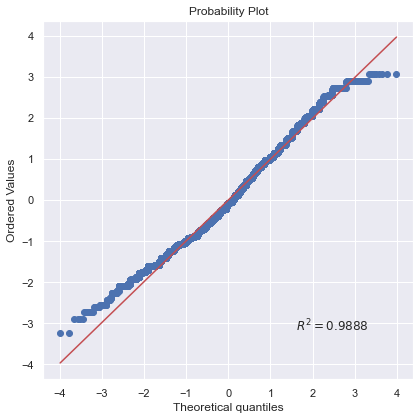

kurtosis de -0.30 <0 legerement platykurtique et skewness de 0.31 <0 legerement décalée à droite
la distribution semble visuellement au QQplot proche d etre normale mais pas complètement

test normalité des residus - test d'Agostino/omnibus pour echantillon moyen grand
Agostino Pvalue:0.00
Si P-VALUE < 0.05: hypothèse H0 est rejetée (i.e. peu probable d etre normalement distribuées).

Hypothèse de normalité non respectée => ANOVA NON PARAMETRIQUE
 kruskall wallis:  0.0  Si pval< 0.05, alors on peut parler de différence significative

post hoc: Les modalités sont bien toutes différentes entre elles 2 à 2


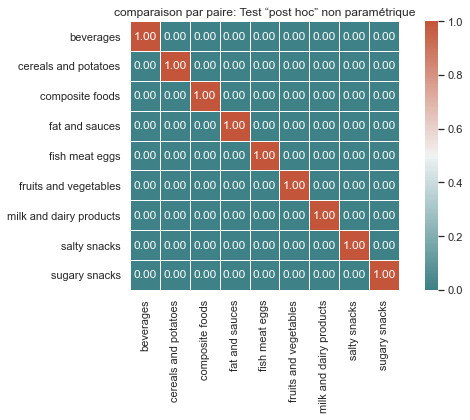

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
#https://fr.wikipedia.org/wiki/Analyse_de_la_variance

temp=data13.loc[:,['nutrition-score-fr_100g','pnns_groups_1', 'pnns_groups_2','addit']].copy()
#attention besoin de rendre les noms plus simples pour utiliser anova
temp.columns=['score','group1','group2','addit']
#on normalise le score (zscore)
temp['score_norm']=(temp['score']-temp['score'].median())/temp['score'].std()

#display(temp2)
#on utilise une regression OLS en specifiant que la variable groupe est categorielle
#type 2 si unbalanced dat
model = ols('score_norm ~ C(group1)', data=temp).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

display(anova_table)
print('pvalue <0.05 donc significative => H0 est rejetée ')
print("il existe au moins un groupe dont la moyenne s'écarte des autres moyennes")
print('')

##################################################################################
##############test des hypothèses

####################normalité
print('Plot des residus: distribution normale ou non?')
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

sns.set_theme(color_codes=True)
stats.probplot((model.resid-model.resid.mean())/model.resid.std(), dist='norm',plot= plt, rvalue= True)
plt.show()

print('kurtosis de %.2f <0 legerement platykurtique et skewness de %.2f <0 legerement décalée à droite' %(model.resid.kurtosis(),model.resid.skew()))
print('la distribution semble visuellement au QQplot proche d etre normale mais pas complètement')
print('')
print("test normalité des residus - test d'Agostino/omnibus pour echantillon moyen grand")
#pvalue proche de 0 -> significative -> donc rejet de H0 : normalité des residus
print('Agostino Pvalue:%.2f' %round(normaltest(model.resid)[1], 4))
print('Si P-VALUE < 0.05: hypothèse H0 est rejetée (i.e. peu probable d etre normalement distribuées).')
print('')
#hypothese de normalité non remplie
# test non parametrique de kruskall wallis pour remplacer ANOVA dans ce cas
# pour ce test on doit donner des arrays de score numeriques groupés par group1 dans notre cas.
#on va utiliser l'objet groupby qui cree des dict (groupe:données) qu on peut voir avec l'attribut groups
#on peut iterer à l'interieur avec une boucle for
# iterable unpacking operator * permet de packer dans une seule variable
##### Merging Iterables With the * Operator
#https://stackabuse.com/unpacking-in-python-beyond-parallel-assignment/

kstat, pval = stats.kruskal(*[group['score_norm'].values for name, group in temp.loc[:,['score_norm','group1']].groupby('group1')])

# Récupérer la p-value
print('Hypothèse de normalité non respectée => ANOVA NON PARAMETRIQUE')
print('\033[1m kruskall wallis: ',pval,'\033[0m Si pval< 0.05, alors on peut parler de différence significative')
# Si pval petit (au moins inférieure à 0.05, alors on peut parler de différence significative)

##################################################################################
##################################################################################
# Pour une analyse un peu plus profonde
#Pour identifier les échantillons correspondants qui s'écartent d'une loi normale commune: on peut utiliser les 
#tests « post-hoc » ou tests de comparaisons multiples dits MCP
#https://scikit-posthocs.readthedocs.io/en/latest/tutorial/
print('')
print('post hoc: Les modalités sont bien toutes différentes entre elles 2 à 2')

import scikit_posthocs as sp
plt.rcParams["figure.figsize"] = [8, 6]
sns.heatmap(
    sp.posthoc_conover(temp, val_col='score_norm', group_col='group1', p_adjust = 'holm'), 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(200, 20, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5)
plt.title('comparaison par paire: Test “post hoc” non paramétrique')
plt.show()


#### 2-D-1-b: Analyse explicative entre la variable catégorielle: GROUPE 2  et score quantitatif: NUTRISCORE : ANOVA
* L'**anova** montre des valeurs significatifs mais l'hypothèse de normalité des résidus n'est pas respectée
* L'**anova non paramétrique Kruskall wallis** valide le fait que la variable qualitative **pnns groupe 2** possède une valeur explicative sur le nutriscore
* Le test **post hoc non paramétrique** montrent que toutes les modalités sont différentes 2 à 2

In [26]:
temp2=temp['group2'].value_counts().reset_index()
lis2=temp2['index'].tolist()

for i in lis2:
    temp.loc[temp.group2==i,'group2']=tabcat2.loc[tabcat2.pnns_groups_2==i,'pnns_groups_2_ren'].reset_index().iloc[0,1]

temp=temp.sort_values(by='group2')

,sum_sq,df,F,PR(>F)
C(group2),"16,499.05",35.00,"2,358.41",0.00
Residual,"4,112.95","20,577.00",NaN,NaN


pvalue <0.05 donc significative => H0 est rejetée 
il existe au moins un groupe dont la moyenne s'écarte des autres moyennes

Plot des residus: distribution normale ou non?


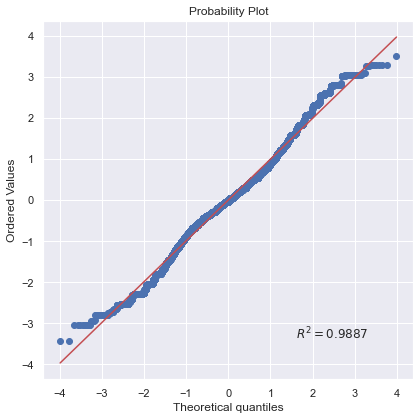

kurtosis de 0.55 >0 legerement leptokurtique et skewness de 0.06 >0 legerement décalée à gauche
la distribution semble visuellement au QQplot proche d etre normale mais pas complètement

test normalité des residus - test d'Agostino/omnibus pour echantillon moyen grand
Agostino Pvalue:0.00
Si P-VALUE < 0.05: hypothèse H0 est rejetée (i.e. peu probable d etre normalement distribuées).

Hypothèse de normalité non respectée => ANOVA NON PARAMETRIQUE
 kruskall wallis:  0.0  Si pval< 0.05, alors on peut parler de différence significative

post hoc: Les modalités ne sont pas toutes différentes entre elles 2 à 2


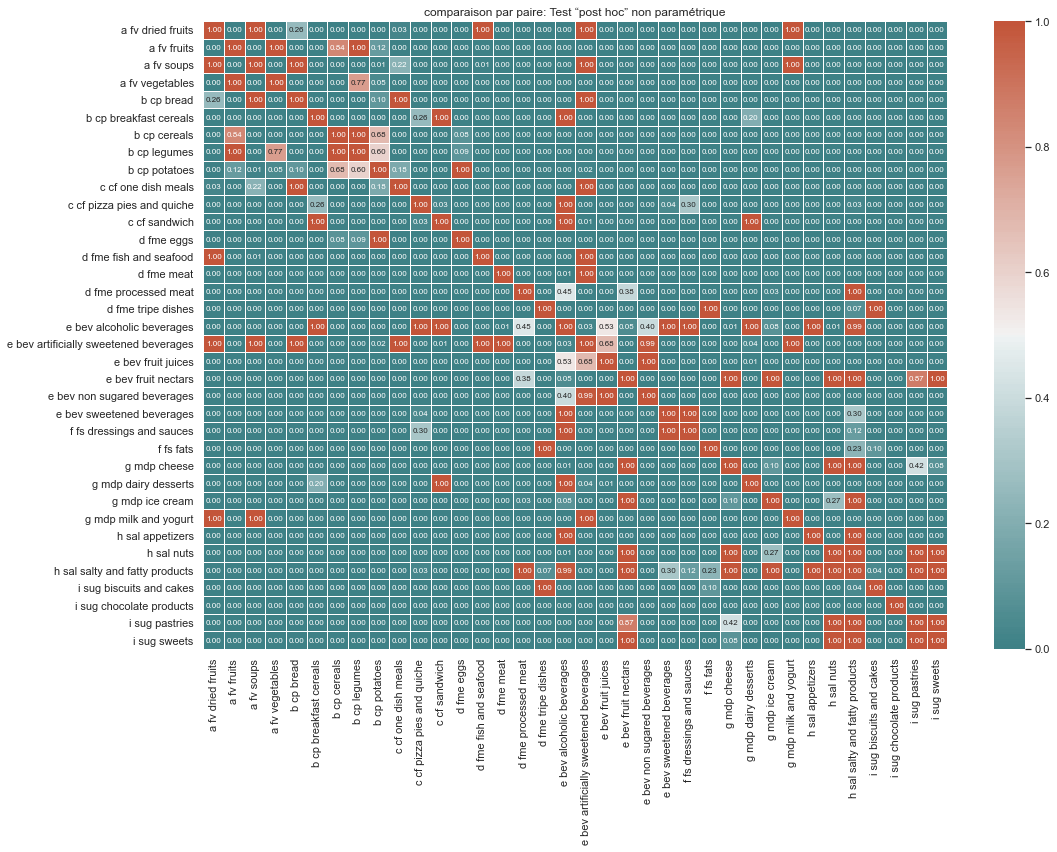

In [27]:


################################################################
model = ols('score_norm ~ C(group2)', data=temp).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

display(anova_table)
print('pvalue <0.05 donc significative => H0 est rejetée ')
print("il existe au moins un groupe dont la moyenne s'écarte des autres moyennes")
print('')

##################################################################################
##############test des hypothèses

####################normalité
print('Plot des residus: distribution normale ou non?')
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

sns.set_theme(color_codes=True)
stats.probplot((model.resid-model.resid.mean())/model.resid.std(), dist='norm',plot= plt, rvalue= True)
plt.show()


print('kurtosis de %.2f >0 legerement leptokurtique et skewness de %.2f >0 legerement décalée à gauche' %(model.resid.kurtosis(),model.resid.skew()))
print('la distribution semble visuellement au QQplot proche d etre normale mais pas complètement')
print('')
print("test normalité des residus - test d'Agostino/omnibus pour echantillon moyen grand")
#pvalue proche de 0 -> significative -> donc rejet de H0 : normalité des residus
print('Agostino Pvalue:%.2f' %round(normaltest(model.resid)[1], 4))
print('Si P-VALUE < 0.05: hypothèse H0 est rejetée (i.e. peu probable d etre normalement distribuées).')
print('')
#hypothese de normalité non remplie
# test non parametrique de kruskall wallis pour remplacer ANOVA dans ce cas
# pour ce test on doit donner des arrays de score numeriques groupés par group1 dans notre cas.
#on va utiliser l'objet groupby qui cree des dict (groupe:données) qu on peut voir avec l'attribut groups
#on peut iterer à l'interieur avec une boucle for
# iterable unpacking operator * permet de packer dans une seule variable
##### Merging Iterables With the * Operator
#https://stackabuse.com/unpacking-in-python-beyond-parallel-assignment/

kstat, pval = stats.kruskal(*[group['score_norm'].values for name, group in temp.loc[:,['score_norm','group2']].groupby('group2')])

# Récupérer la p-value
print('Hypothèse de normalité non respectée => ANOVA NON PARAMETRIQUE')
print('\033[1m kruskall wallis: ',pval,'\033[0m Si pval< 0.05, alors on peut parler de différence significative')
# Si pval petit (au moins inférieure à 0.05, alors on peut parler de différence significative)

##################################################################################
##################################################################################
# Pour une analyse un peu plus profonde
#Pour identifier les échantillons correspondants qui s'écartent d'une loi normale commune: on peut utiliser les 
#tests « post-hoc » ou tests de comparaisons multiples dits MCP
#https://scikit-posthocs.readthedocs.io/en/latest/tutorial/
print('')
print('post hoc: Les modalités ne sont pas toutes différentes entre elles 2 à 2')

import scikit_posthocs as sp
plt.rcParams["figure.figsize"] = [16, 12]
sns.heatmap(
    sp.posthoc_conover(temp, val_col='score_norm', group_col='group2', p_adjust = 'holm'), 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(200, 20, n=200),
    annot=True,
    annot_kws={"fontsize":8},
    fmt='.2f',
    linewidths=.5)
plt.title('comparaison par paire: Test “post hoc” non paramétrique')
plt.show()

#### 2-D-1-c: Analyse explicative entre la variable catégorielle: additif(présence ou non)  et score quantitatif: NUTRISCORE : ANOVA
* L'**anova** montre des valeurs significatifs mais l'hypothèse de normalité des résidus n'est pas respectée
* L'**anova non paramétrique Kruskall wallis** valide le fait que la variable qualitative **présence d'additif** possède une valeur explicative sur le nutriscore

,sum_sq,df,F,PR(>F)
C(addit),"2,100.23",1.00,"2,338.39",0.00
Residual,"18,511.77","20,611.00",NaN,NaN


pvalue <0.05 donc significative => H0 est rejetée 
il existe au moins un groupe dont la moyenne s'écarte des autres moyennes

Plot des residus: distribution normale ou non?


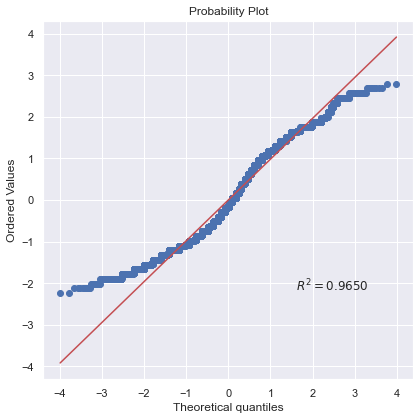

kurtosis de -0.97 <0 legerement platykurtique et skewness de 0.26 >0 legerement décalée à gauche
la distribution n'est pas normale au QQplot

test normalité des residus - test d'Agostino/omnibus pour echantillon moyen grand
Agostino Pvalue:0.00
Si P-VALUE < 0.05: hypothèse H0 est rejetée (i.e. peu probable d etre normalement distribuées).

Hypothèse de normalité non respectée => ANOVA NON PARAMETRIQUE
 kruskall wallis:  0.0  Si pval< 0.05, alors on peut parler de différence significative


In [28]:
################################################################
model = ols('score_norm ~ C(addit)', data=temp).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

display(anova_table)
print('pvalue <0.05 donc significative => H0 est rejetée ')
print("il existe au moins un groupe dont la moyenne s'écarte des autres moyennes")
print('')

##################################################################################
##############test des hypothèses

####################normalité
print('Plot des residus: distribution normale ou non?')
plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

sns.set_theme(color_codes=True)
stats.probplot((model.resid-model.resid.mean())/model.resid.std(), dist='norm',plot= plt, rvalue= True)
plt.show()


print('kurtosis de %.2f <0 legerement platykurtique et skewness de %.2f >0 legerement décalée à gauche' %(model.resid.kurtosis(),model.resid.skew()))
print("la distribution n'est pas normale au QQplot")
print('')
print("test normalité des residus - test d'Agostino/omnibus pour echantillon moyen grand")
#pvalue proche de 0 -> significative -> donc rejet de H0 : normalité des residus
print('Agostino Pvalue:%.2f' %round(normaltest(model.resid)[1], 4))
print('Si P-VALUE < 0.05: hypothèse H0 est rejetée (i.e. peu probable d etre normalement distribuées).')
print('')
#hypothese de normalité non remplie
# test non parametrique de kruskall wallis pour remplacer ANOVA dans ce cas
# pour ce test on doit donner des arrays de score numeriques groupés par group1 dans notre cas.
#on va utiliser l'objet groupby qui cree des dict (groupe:données) qu on peut voir avec l'attribut groups
#on peut iterer à l'interieur avec une boucle for
# iterable unpacking operator * permet de packer dans une seule variable
##### Merging Iterables With the * Operator
#https://stackabuse.com/unpacking-in-python-beyond-parallel-assignment/

kstat, pval = stats.kruskal(*[group['score_norm'].values for name, group in temp.loc[:,['score_norm','addit']].groupby('addit')])

# Récupérer la p-value
print('Hypothèse de normalité non respectée => ANOVA NON PARAMETRIQUE')
print('\033[1m kruskall wallis: ',pval,'\033[0m Si pval< 0.05, alors on peut parler de différence significative')
# Si pval petit (au moins inférieure à 0.05, alors on peut parler de différence significative)

#### 2-D-2: Analyse descriptive multivariée : ACP : reduction de dimension des variables quantitatives
* entre **85 et 90% de la variance** est expliquée par **les 4 premiers facteurs**
    * Par ailleurs la qualité de représentation des variables sur les composantes , exprimée par le cos2, est quasi nulle à partire de la composante5
* les 2 premiers facteurs sont relativement corrélés au nutriscore
    * La première composante est une composante gras/sucrée
    * La 2 ème composantes est plutot sel/gras
    * La 3 ème est plutot une composante anti fibre
    * et la 4 èeme anti protéine
* Au final le **premier plan factoriel** représente un angle de vision **"mal-bouffe"**
* Alors que le **2éme** est plutot **anti "nourriture saine"**


In [29]:
#standardisation

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn.impute import SimpleImputer

#normalisation/standardisation des variables numeriques par groupes
j=data13.filter(regex='_100g$',axis=1).columns.tolist()
#on remove le score qui est la variable endogène
#j.remove('nutrition-score-fr_100g')

jcat=j.copy()
jcat.append('addit')
jcat.append('pnns_groups_1')
jcat.append('pnns_groups_2')
jcat.append('nutrition_grade_fr')

#bouchage de trou
#deja fait à l'étape data13

#display(temp)
#display(gt)
temp=data13.copy()

#normalisation
#standard = preprocessing.scale(temp.loc[:,j])
#normalisation robuste :-mediane/ iqr
standard = preprocessing.robust_scale(temp.loc[:,j])
stand=pd.concat([pd.DataFrame(data=standard),temp['addit'],temp['pnns_groups_1'],temp['pnns_groups_2'],temp['nutrition_grade_fr']], axis=1)
stand.columns=jcat

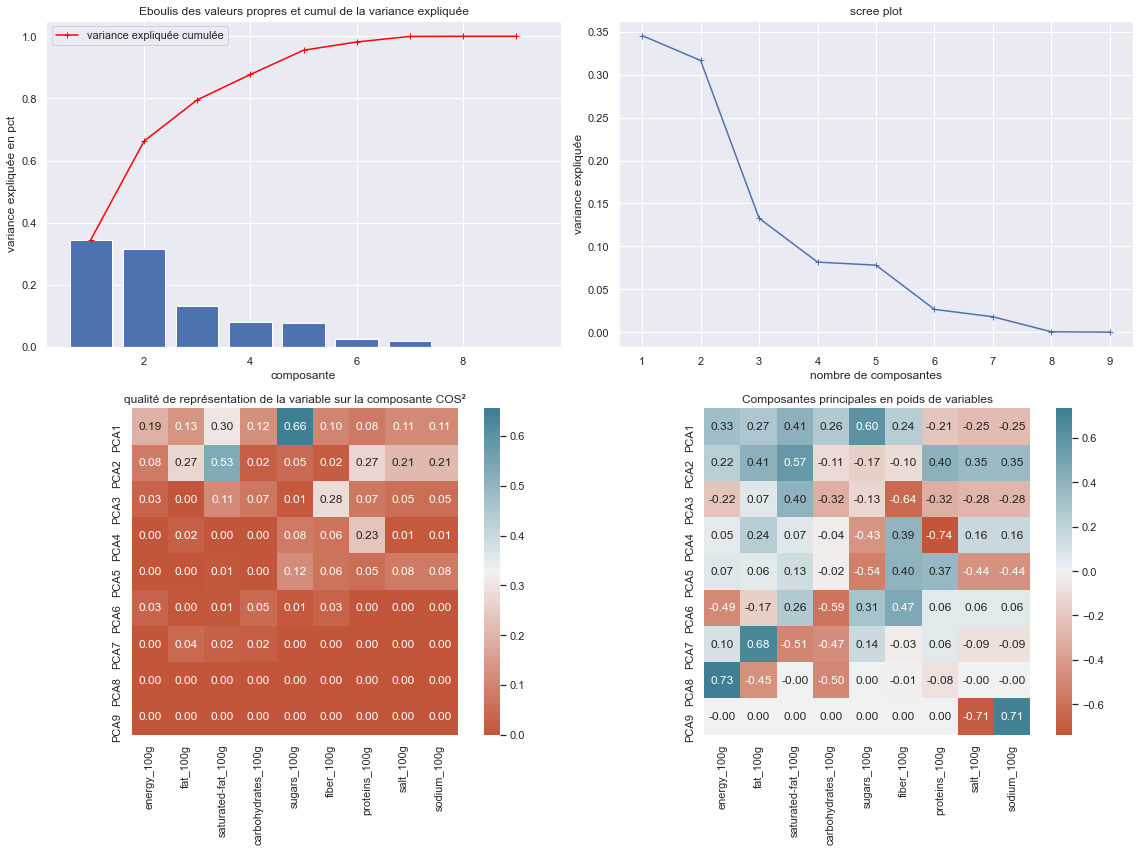

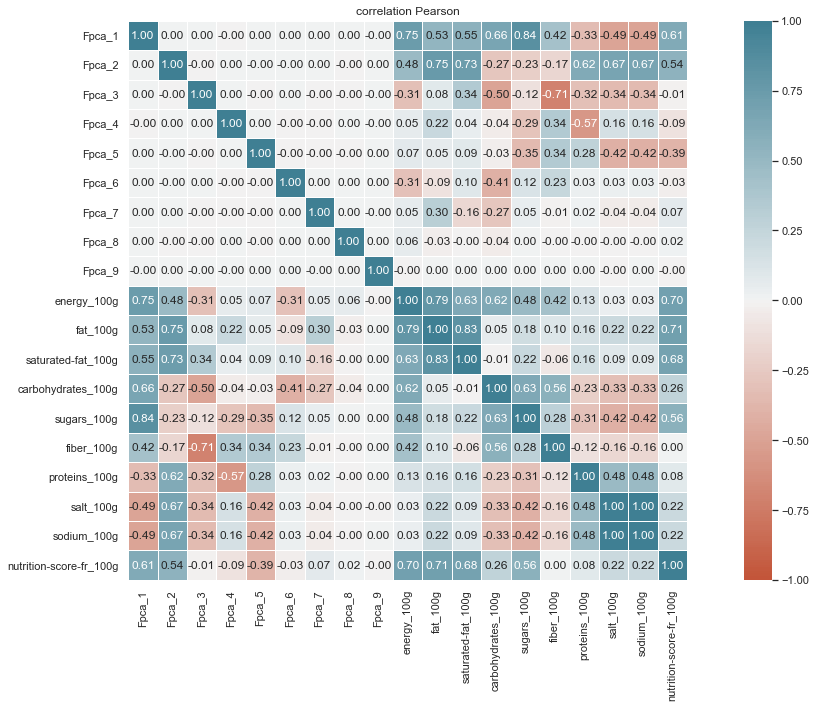

Output()

In [30]:
import math
#initialisation du PCA
#on choisit l'option de trouver le nombre de facteurs que l'on souhaite garder en preprocessing
#decomposition en valeurs singulaieres : SVD : 
#(plus general que la decomposition en vp qui ne concernent que sur certaines matrices carrées)

pca = PCA(svd_solver='full')

#fit_transform prend en entree les donnees [obs,variables]
#et retourne [obs, composantes] par importance de composantes

#on retire le score pour l ACP
j.remove('nutrition-score-fr_100g')
projection = pca.fit_transform(pd.DataFrame(stand.loc[:,j]).to_numpy())
#verif
#display(np.dot(np.squeeze(pd.DataFrame(stand.loc[0,j]).to_numpy()),pca.components_[0,:]))
#display(projection)
projection2=pd.concat([pd.DataFrame(data=projection),stand], axis=1)
projection2.columns = ["Fpca_" + str(i+1) for i in range(pca.n_components_)]+jcat
#liste des colonnes quantitatives avec pca
j.append('nutrition-score-fr_100g')
jplus=["Fpca_" + str(i+1) for i in range(pca.n_components_)]+j

#display(projection)
#display(projection2)

#composantes principales dans l'espace des variables[compo,var]
#display(pca.components_)
#variance expliquée pour chaque composante
#display(pca.explained_variance_)
#pourcentage de variance expliquée pour chaque composante
#display(pca.explained_variance_ratio_)
#valeurs singuliere
#display(pca.singular_values_)
#nombre de composante
#display(pca.n_components_)


#diagramme des variances expliquée
plt.rcParams["figure.figsize"] = [16, 12]


plt.subplot(2,2,1)
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_ )
plt.ylabel('variance expliquée en pct')
plt.xlabel('composante')
plt.title('Eboulis des valeurs propres et cumul de la variance expliquée')
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         marker='+',
         label="variance expliquée cumulée")
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_,marker='+',)
plt.xlabel('nombre de composantes')
plt.ylabel('variance expliquée')
plt.title('scree plot')


#en SVD : pourcentage de variance expliquée correspond aux valeurs singulieres au carré normalisé (somme=1)
#pvd et svd assez proche : lambda(~vp)=sigma²(~vs)/ (n obs-1)
#correl (facteur/variable x)=sqrt(lambda) * poids = sigma / sqrt(n obs -1) * poids

#plt.subplot(2,2,3)
#plt.bar(range(1,len(pca.singular_values_)+1),pca.singular_values_ )
#plt.ylabel('valeurs singulieres')
#plt.xlabel('composante')
#plt.title('valeurs singulières')
                        #T veut dire transpose (on ne peut transposer qu une matrice)
                        #la somme des cos2 par facteur vaut 1
                        # le cos2 c est la correl au carré (pour la correl voir plus haut)
            
            

    #Un cos2 élevé indique une bonne représentation de la variable sur les axes principaux en considération. 
    #Dans ce cas, la variable est positionnée à proximité de la circonférence du cercle de corrélation.
    #Un faible cos2 indique que la variable n’est pas parfaitement représentée par les axes principaux. 
    #Dans ce cas, la variable est proche du centre du cercle.
    
    #Les valeurs de cos2 sont utilisées pour estimer la qualité de la représentation
    #Plus une variable est proche du cercle de corrélation, meilleure est sa représentation sur la carte de l’ACP 
    #(et elle est plus importante pour interpréter les composantes principales en considération)
    #Les variables qui sont proche du centre du graphique sont moins importantes pour les premières composantes.


j.remove('nutrition-score-fr_100g')
ax=plt.subplot(2,2,3)
sns.heatmap((((pca.components_.T*pca.singular_values_).T/math.sqrt(projection2.shape[0]-1))**2),
                 cmap=sns.diverging_palette(20, 220, n=200),
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(j),
                 annot=True,
                 fmt='.2f',
                 cbar_kws={"orientation": "vertical"},
                ax=ax)
ax.set_aspect('equal')
ax.set_title("qualité de représentation de la variable sur la composante COS²")


#composantes principales
ax=plt.subplot(2,2,4)
sns.heatmap(pca.components_,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(j),
                 annot=True,
                 fmt='.2f',
                 cbar_kws={"orientation": "vertical"},
                ax=ax)
ax.set_aspect('equal')
ax.set_title("Composantes principales en poids de variables")

plt.show()
j.append('nutrition-score-fr_100g')

#correlation
corr1 = projection2.loc[:,jplus].corr(method ='pearson')
#corr2 = projection2.loc[:,jplus].corr(method ='spearman')

plt.figure(figsize=(16,10))

ax = plt.subplot(1,1,1)

sns.heatmap(
    corr1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    ax=ax)
ax.set_title('correlation Pearson')




plt.show()

#projection2.columns = ['score' if x=='nutrition-score-fr_100g' else x for x in projection2.columns]
#reg_quant_uni_ols(data=projection2,xreg='Fpca_2',yreg='score')

import math
########################################################################################
#fonction ocr cercle de correlation
def display_circles(pcs, n_comp, n_obs , psv, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    #pcs composantes principales dans l'espace des variables [compo,var]
    #n_comp nombre de composantes
    #pca
    #axis_ranks : liste de tuples (duet de rangs d'axes pour les plans)
    
    plt.rcParams["figure.figsize"] = [16, 16]
    z=0
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        z=z+1
        if d2 < n_comp:

            # initialisation de la figure
            ax = plt.subplot(2,2,z)

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
                #en general si moins de 30 composantes : cadre classique de correlation
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
                #sinon on boucle 
            else :
                #a retravailler si besoin
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            #########################################################################################
            if pcs.shape[1] < 30 :
                #attention SVD donc les correlations sont les poids*valeurs singuliers / sqrt(nobs-1)
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),psv[d1]*pcs[d1,:]/math.sqrt(n_obs-1), psv[d2]*pcs[d2,:]/math.sqrt(n_obs-1), 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
            #########################################################################################
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="blue", alpha=1)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes x et y (Fi et Fj), avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
    plt.show(block=False)
########################################################################################
#display_circles(pca.components_, pca.n_components_,projection2.shape[0],pca.singular_values_ ,pca, [(0,1),(2,3),(4,5),(6,7)], labels = np.array(j))

#plan 1 F1/F2 : 
    #F1+ energy / nutriscore / gras / sucre
    #F2+ sel / prot
    #F2- sucres
    
from matplotlib.lines import Line2D  # for legend handle    
########################################################################################
#fonction ocr projection des individus sur lesplans
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, colormap, colorgroup, size=3, labels=None, alpha=1, illustrative_var=None,
                             annot=None, annotcol=None, colorcol=None, namtitle="individus"):
    z=0
    plt.rcParams["figure.figsize"] = [16, 16]
    for d1,d2 in axis_ranks:
        z=z+1
        if d2 < n_comp:
 
            # initialisation de la figure
            ax = plt.subplot(2,2,z)
        
            # affichage des points
            if illustrative_var is None:
                ####################################
                plt.scatter(X_projected[:, d1], X_projected[:, d2], c=colorgroup.map(cm),s=size, alpha=0.7)
                if (annot==True):
                    for i in range(len(annotcol)): 
                        plt.annotate(annotcol[i],(X_projected[i, d1], X_projected[i, d2]),color=colorcol[i])
                
                # add a legend
                handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in cm.items()]
                ax.legend(title='nutrigrade', handles=handles, bbox_to_anchor=(0.85, 1), loc='upper left')
                ####################################
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des "+str(namtitle)+" (sur F{} et F{})".format(d1+1, d2+1))
    plt.show(block=False)
                

cm = {'a':'tab:blue', 'b':'tab:green', 'c':'tab:pink','d':'tab:orange', 'e':'tab:red'}
#display_factorial_planes(projection, pca.n_components_, pca, [(0,1),(2,3),(4,5),(6,7)], cm, projection2.loc[:,'nutrition_grade_fr'] )

list2=["Fpca_" + str(i+1) for i in range(pca.n_components_)]
#print(list2)

proj=projection2.groupby(['pnns_groups_1','nutrition_grade_fr'])[list2].median()
proj=proj.reset_index()
proj['color']=proj['nutrition_grade_fr'].map(cm)
#display(proj)
projnp=proj.loc[:,list2].to_numpy()
#display_factorial_planes(projnp, pca.n_components_, pca, [(0,1),(2,3),(4,5),(6,7)], cm, proj.loc[:,'nutrition_grade_fr'], size=10, annot=True, annotcol=proj.loc[:,'pnns_groups_1'], colorcol=proj.loc[:,'color'], namtitle='medianes des groupes 1' )

###########################################################################################################################


button3 = widgets.ToggleButtons(
    options=['Cercle', 'Projection'],
    description='ACP: TYPE DE GRAPHIQUES',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
    style={'description_width': 'initial'},
    layout = widgets.Layout(width='800px', height='auto'),
)
button4 = widgets.ToggleButtons(
    options=['Individus', 'Groupe1'],
    description='REPRESENTATION',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
    style={'description_width': 'initial'},
    layout = widgets.Layout(width='800px', height='auto'),
)



button5 = widgets.IntSlider(
    value=1,
    min=1,
    max=4,
    step=1,
    description='PLAN FACTORIEL',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = widgets.Layout(width='600px', height='auto'),
    style={'description_width': 'initial'},
    display='flex',
    flex_flow='column',
    align_items='stretch'
)

ui3 = widgets.VBox([button3])
ui4 = widgets.VBox([button4])
ui5 = widgets.VBox([button5])
def eval1_pca(a,b,c):
    #selection = button.get_interact_value()
    if a=='Cercle':
        display(ui3,ui5)
        display_circles(pca.components_, pca.n_components_,projection2.shape[0],pca.singular_values_ ,
                pca, [(c*2-2,c*2-1)], labels = np.array(j))
    elif a=='Projection':
        display(ui3, ui4,ui5)
        if b=='Individus':
            display_factorial_planes(projection, pca.n_components_,
                pca, [(c*2-2,c*2-1)], cm, projection2.loc[:,'nutrition_grade_fr'] )
        elif b=='Groupe1':
            display_factorial_planes(projnp, pca.n_components_, 
                pca, [(c*2-2,c*2-1)], cm, proj.loc[:,'nutrition_grade_fr'], size=10, annot=True,
                annotcol=proj.loc[:,'pnns_groups_1'], colorcol=proj.loc[:,'color'], namtitle='medianes des groupes 1' )   
#affichage des widget avec evaluation
outa = widgets.interactive_output(eval1_pca, {'a': button3,'b': button4,'c': button5})
display(outa)

#### 2-E: Analyse explicative multivariée: Regression multiple
* Suite à notre analyse, nous pouvons tenter une explication multivariée du nutriscore sous forme de régression multiple.
    * concernant les données quantitatives nutritionnelles, nous avons le choix d'utiliser:
        * - quelques facteurs de l'ACP: les 4 premiers par exmple
        * - ou bien les variables elles mêmes en veillant à ne pas garder des variables trop colinéaires (sodium ou sel par exemple mais pas les 2)
    * concernant les données catégorielles , nous pouvons garder la présence d'additif et au choix le groupe 1 ou le groupe 2
        * le groupe 2 possédant certainement un peu trop de catgégories quasi redondantes
* Nous obtenons avec L'ACP , les additifs ainsi que le groupe 1: un **R2 de 0.85** avec tous les **coefficients significatifs**:
    * les facteurs 1 et 2, dits de "malbouffe" et la présence d'additif augmente le score modélisé 
    * le facteur 3 dit "nourriture saine" est pris en négatif ce qui fait du sens
    * les résidus sont quasi normaux , homoscedastiques  et la linearité ets presque respectée
* Nous obtenons avec les variables nutritionnelles (sans sodium ni fat) , les additifs ainsi que le groupe 1: un **R2 de 0.90** avec tous les **coefficients significatifs**:
    * L'energie, les acides gras, le sucre, le sel et la presence d'additif augmente le nutriscore et donc le grade
    * Les hydrates de carbone , les fibres et les protéines diminue le nutriszcore
    * les résidus sont quasi normaux , homoscedastiques  et la linearité ets presque respectée

In [45]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from IPython.display import clear_output

def reg_quant_multi_ols(data,xreg,yreg,lisgraph):
    #######################################################################
    #https://delladata.fr/la-regression-lineaire-simple-avec-le-logiciel-r/
    #regression linéaire:
        #test T de significativité valable que si
        #hypothese:
            #independance des residus (la plus importante): 
                # attention autocorrelation dans les series temp /ACF: lagplot / pvalue durbin watson < 0.05 -> H0 independance rejetée
            #homogeneité des résidus (la plus importante):
                #sqrt standardized residual vs fitted plot -> observation de la droite de reg (si plat c'est homogene)
                #test de breusch pagan : pvalue <0.05 -> H0 homogeneité rejetée
            #normalité des residus : 
                #qq plot
                #https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411
                #test shapiro wilk/ ks / jarque bera/  : pvalue >0.05 -> H0 normalité rejetée
            #hypothèse de linéarité
                #residual vs fitted plot -> observation de la droite de reg (si plat c'est homogene)
        #verifier les données influentes
                #fonction influence/indexplot
                    #hat value plot: poids de chaque valeur sur sa propore estimation
                    #p value de bonferroni : pvalue <0.05 = outliers
                    #residus studentizés -> outliers
                    #distance de cook: influence sur l estimation des parametres
                    
        #https://delladata.fr/regression-lineaire-simple-quand-les-hypotheses-ne-sont-pas-satisfaites/         
        #si hypothèse non respectée
            #linearité non respectée, on se contente de la monotonie
                #test de correlation de spearman qui ne requiert que l'independance des données
                #ou envisager transformation des variables (sqrt, ln, log log1p) pour ameliorer la linearité
            #independance ds données
                #si structure d autocorrelation , rajouté structure AR avec un GLS (plus faible est le critere aic , meilleur est le modèle)
            #normalité non respectée
                #1-renoncer à la linearité en faisant un test de spearman
                #ou 2-utiliser un teste de permutation pour voir voir si la pente est differente de 0
                #ou 3-appliquer une transformation sur la reponse (log, racine carrée , box cox)
            #homogeneité non respectée (donc erreur sous estimée)
                #1-renoncer à la linearité en faisant un test de spearman
                #ou 2-utiliser un teste de permutation pour voir voir si la pente est differente de 0
                #ou 3-appliquer une transformation sur la reponse (log, racine carrée , box cox).
                #ou 4-utiliser des estimateurs sandwich pour la matrice de var-covar
    #model ols
    y = data[yreg]
    X = data[xreg]
    #on ajoute une constante au cas ou
    X = sm.add_constant(X)


    mod = sm.OLS(y,X, missing='drop').fit()
    #what we get:
    #https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults
    print(mod.summary())

    #R2 de 1=> explication totale
    #R2 adjusté: important pour du multivarié 
    #F stat pvalue: H0 rejete si proche de 0 => donc significatif
    #P omnibus: 1 si residus parfaitement normaux
    #kurtosis tres superieur à 0 (leptokurtique) -> se rapproche d un dirac
    #P jarque-bera: autre facon de faire de l omnibus en prenant en compte la skew et la kurtosis
    #Durbin watson -> mesure d'homoscedasticité
    #conditon number: si grand -> multicollinearite

    #########################################################################
    #verif hypothèses
    #AR : 

    print("")
    print("H0 independance des données, Durbin Watson: "+str("{:.2f}".format(sms.durbin_watson(mod.resid)))+" , pas d'autocor si=2")
    print("H0 homogeneite des résidus,Pvalue Breusch Pagan: "+str("{:.2f}".format(sms.het_breuschpagan(mod.resid,mod.model.exog)[3]))+" , H0 rejeté si p<0.05")
    print("H0 homogeneite des résidus,Pvalue Goldfeld-Quandt: "+str("{:.2f}".format(sms.het_goldfeldquandt(mod.resid,mod.model.exog)[1]))+" , H0 rejeté si p<0.05")
    print("H0 normalité des résidus,Pvalue Jarque Bera: "+str("{:.2f}".format(sms.jarque_bera(mod.resid)[1]))+" , H0 rejeté si p<0.05")
    #print("H0 linearité,Pvalue Harvey-Collier multiplier: "+str("{:.2f}".format(sms.linear_harvey_collier(mod)[1]))+" , H0 rejeté si p<0.05")
    #########################################################################
    #chart
    sns.set_theme(color_codes=True)
    plt.figure(figsize=(16,6))

    a = mod.params[xreg]
    b = mod.params['const']
    
    ############

    ############
    if 'fitted/y' in lisgraph:
        ax1 = plt.subplot(1,1,1)
        if mod.f_pvalue<=0.05:
            ax1.set_title(str("{:.2f}".format(mod.rsquared))+'--P:'+str("{:.2f}".format(mod.f_pvalue))+' signific')
        else:
            ax1.set_title(str("{:.2f}".format(mod.rsquared))+'--P:'+str("{:.2f}".format(mod.f_pvalue))+'non signific')
        ax1=sns.regplot(x=data[yreg], y=mod.fittedvalues,
              fit_reg=True,
              scatter=True,
              ci=False,
              lowess=False,
              line_kws={'color': 'red', 'lw': 2, 'alpha': 1},
              scatter_kws={'s': 3})
        ax1.set_xlabel("score")
        ax1.set_ylabel("score fitté")
        plt.show()
    ############

    
    plt.figure(figsize=(16,6))
    if 'QQplot' in lisgraph:
        ax2 = plt.subplot(1,3,1)
        #normality_plot, stat=stats.probplot(mod.resid, dist='norm',plot= plt, rvalue= True)
        normality_plot, stat=stats.probplot(mod.get_influence().resid_studentized_internal, dist='norm',plot= plt, rvalue= True)
        ax2.set_title('Normalité -- QQplot')
        ax2.get_lines()[0].set_markersize(3.0)
        ax2.set_xlabel("quantiles theoriques")
        ax2.set_ylabel("residus standardisés")
        ax2 = normality_plot
    
    ############
    if 'homoscedasticité(attente)' in lisgraph:
        ax3 = plt.subplot(1,3,2)
        ax3.set_title('homoscédasticité des résidus')
        #ax5=plt.scatter(x=mod.fittedvalues, y=np.sqrt(np.abs(mod.get_influence().resid_studentized_internal)), alpha=0.5)
        ax3=sns.regplot(x=mod.fittedvalues, y=np.sqrt(np.abs(mod.get_influence().resid_studentized_internal)),
              scatter=True,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 2, 'alpha': 1},
              scatter_kws={'s': 3})
        ax3.set(xlabel='valeurs fittées', ylabel='$\sqrt{|residus standardisés|}$')
    
    ############
    if 'linéarité(attente)' in lisgraph:
        ax4 = plt.subplot(1,3,3)
        ax4.set_title('Linéarité')
        #ax6=plt.scatter(x=mod.fittedvalues, y=mod.resid, alpha=0.5)
        ax4=sns.regplot(x=mod.fittedvalues, y=mod.resid,
              scatter=True,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 2, 'alpha': 1},
              scatter_kws={'s': 3})
        ax4.set(xlabel='valeurs fittées', ylabel='residus')
    
    plt.show()
    
##############################################################################################################    
#copy pour changer la vue initiale
projection3=projection2.copy()
#normalement pas d'element vide car on a imputer avant
projection3.loc[projection3.addit.isnull(),'addit']=np.nan

# on rajoute les variables de categories

#quand on cree les indicatrices d'une variable categorielle , pour evite de la multicollinearite, on enleve une colonne avec le drop_first car se deduit des autres
dummies_g1 = pd.get_dummies(projection3["pnns_groups_1"],drop_first=True)
group1_lis=dummies_g1.columns.values.tolist()
dummies_g2 = pd.get_dummies(projection3["pnns_groups_2"],drop_first=True)
group2_lis=dummies_g2.columns.values.tolist()

#concat
projection3 = pd.concat([projection3, dummies_g1, dummies_g2], axis=1)
#renommage
projection3.columns = ['score' if x=='nutrition-score-fr_100g' else x for x in projection3.columns]
projection3.columns = ['additif' if x=='addit' else x for x in projection3.columns]
############################################################################################################## 
#bouton
choice1 = widgets.SelectMultiple(
    options=['Fpca_1', 'Fpca_2', 'Fpca_3', 'Fpca_4',
            'Fpca_5', 'Fpca_6', 'Fpca_7', 'Fpca_8', 'Fpca_9'],
    #value=['Facteur 1'],
    #rows=10,
    description='ACP',
    disabled=False
)
choice2 = widgets.SelectMultiple(
    options=['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
            'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g'],
    #value=['energy_100g'],
    #rows=10,
    description='Nutriments',
    disabled=False
)
choice3 = widgets.SelectMultiple(
    options=['groupe_1', 'groupe_2', 'additif'],
    #value=['groupe_1'],
    #rows=10,
    description='Catégories',
    disabled=False
)
choice4 = widgets.SelectMultiple(
    options=['fitted/y', 'QQplot', 'homoscedasticité(attente)','linéarité(attente)'],
    #value=['fitted/y'],
    #rows=10,
    description='Graphiques',
    disabled=False
)
regrun=widgets.Button(
    description='Run',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

from ipywidgets import HBox, VBox
from IPython.display import display

tab1 = VBox(children=[HBox(children=[choice1,choice2,choice3])])
tab2 = VBox(children=[HBox(children=[choice4,regrun])])
tab3 = VBox(children=[tab1,tab2])
display(tab3)

#le petit truc important pour faire de la place pour la sortie de la fonction
out = widgets.Output()
display(out)
############################################################################################################## 
from IPython.display import display,clear_output

def on_button_clicked(b):
    #recuperation des valeurs des box
    lisv1=choice1.value
    lisv2=choice2.value
    lisv3=choice3.value
    lisg=choice4.value
    #concat liste variables explicatives
    lisv=list(lisv1)+list(lisv2)
    if 'groupe_1' in list(lisv3):
        lisv=lisv+group1_lis
    if 'groupe_2' in list(lisv3):
        lisv=lisv+group2_lis
    if 'additif' in list(lisv3):
        lisv.append('additif')
    
    #le petit truc important (le with out) pour faire de la place pour la sortie de la fonction
    with out:
        clear_output()
        #display(tab3)
        reg_quant_multi_ols(data=projection3,xreg=lisv,yreg='score',lisgraph=list(lisg))
        

#fonction sur bouton clické
regrun.on_click(on_button_clicked)

Output()